In [178]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import math
import scipy
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import ast
import os
from datetime import datetime
import warnings



In [179]:
##Reading the dataset
train = pd.read_csv("../input/train.csv", low_memory=False)

In [180]:
 def conv_to_gen(x):
        if isinstance(x, int) == False:
            g = ast.literal_eval(x)
            gen = [i['name'] for i in g]
            return len(gen)
        else:
            return x

In [181]:
def data_clean(df):
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 18) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 18)  & (df['release_year'] < 100), "release_year"] += 1900
    power_six = df.id[train.budget > 1000][df.revenue < 100]
    for k in power_six :
        df.loc[df['id'] == k,'revenue'] =  df.loc[df['id'] == k,'revenue'] * 1000000
    
    df = df.dropna(axis=1, thresh=int(0.82*len(df)))
    df = df.dropna(axis=0)
    df = df.filter(['id','budget','genres','popularity','production_companies','release_year',
                    'release_month','runtime','spoken_languages','revenue'])
    plt.figure(figsize=(20,20))
    sns.set_context("paper", font_scale=1)
    ##finding the correllation matrix and changing the categorical data to category for the plot.
        
    df['genres'] = df['genres'].apply(lambda x: conv_to_gen(x))
    df['production_companies'] = df['production_companies'].apply(lambda x: conv_to_gen(x))
    df['spoken_languages'] = df['spoken_languages'].apply(lambda x: conv_to_gen(x))
    df['release_month'] = df['release_month'].astype('str')
    df = pd.get_dummies(df, drop_first=False)
    
    sns.heatmap(df.assign(genres=df.genres.astype('category').cat.codes,
                             production_companies=df.production_companies.astype('category').cat.codes,   
                            spoken_languages=df.spoken_languages.astype('category').cat.codes).corr(), 
                             annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)
    
    return df
    
    
    

,id,budget,genres,popularity,production_companies,release_year,runtime,spoken_languages,revenue,release_month_1,release_month_10,release_month_11,release_month_12,release_month_2,release_month_3,release_month_4,release_month_5,release_month_6,release_month_7,release_month_8,release_month_9
0,1,14000000,1,6.575393,3,2015,93.0,1,12314651,0,0,0,0,1,0,0,0,0,0,0,0
1,2,40000000,4,8.248895,1,2004,113.0,1,95149435,0,0,0,0,0,0,0,0,0,0,1,0
2,3,3300000,1,64.299990,3,2014,105.0,1,13092000,0,1,0,0,0,0,0,0,0,0,0,0
8,9,0,5,6.902423,3,1996,100.0,1,34327391,0,0,0,0,1,0,0,0,0,0,0,0
9,10,6000000,2,4.672036,1,2003,91.0,1,18750246,0,0,0,0,0,0,1,0,0,0,0,0


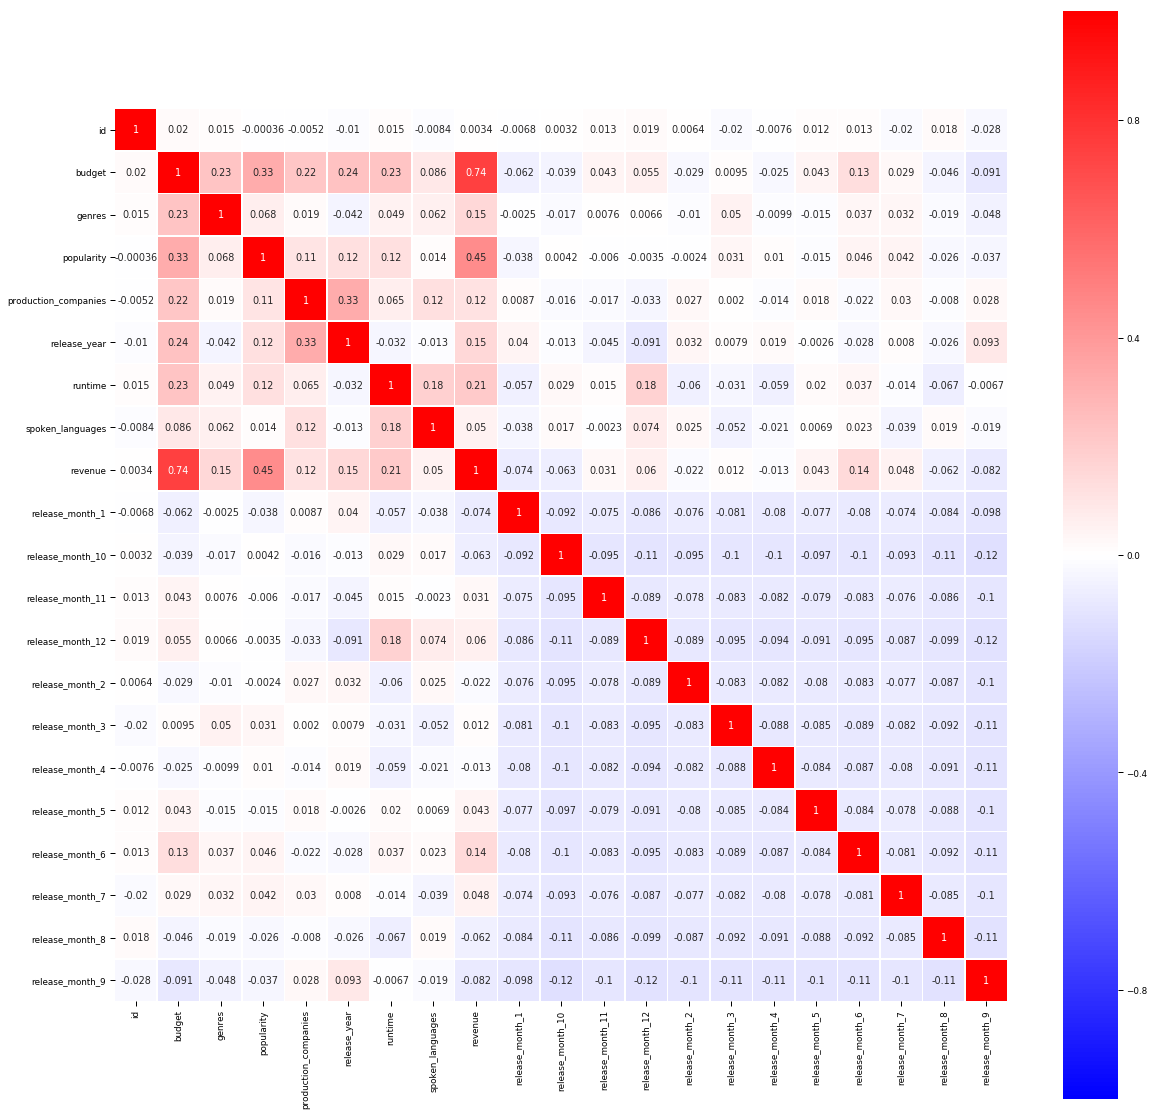

In [182]:
train = data_clean(train)
train.head(5)

In [183]:
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)


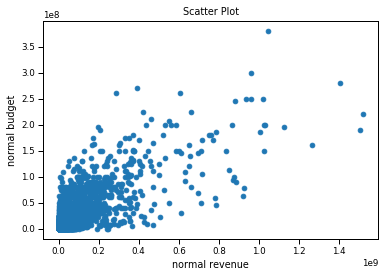

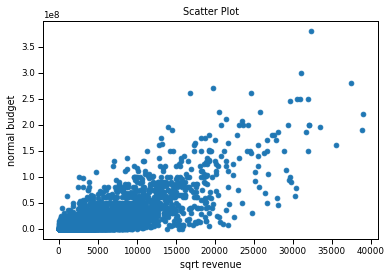

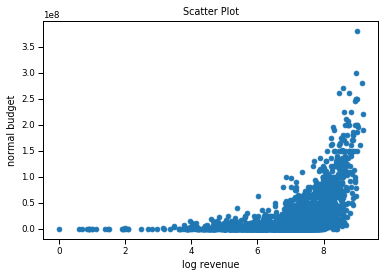

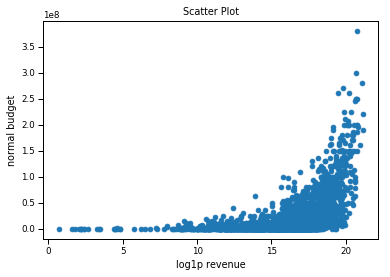

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


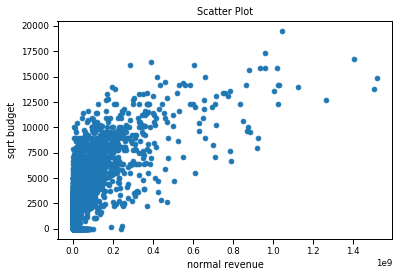

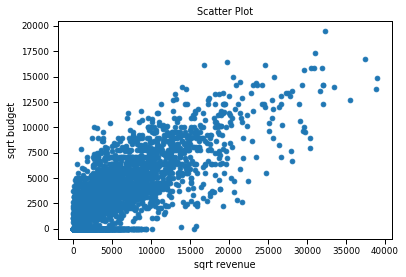

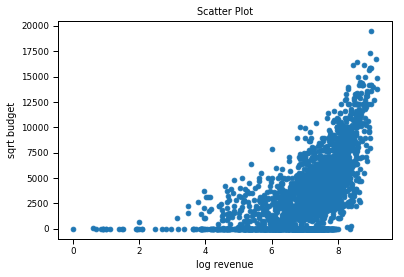

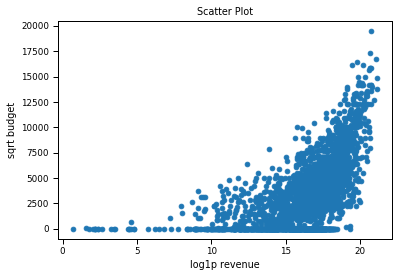

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


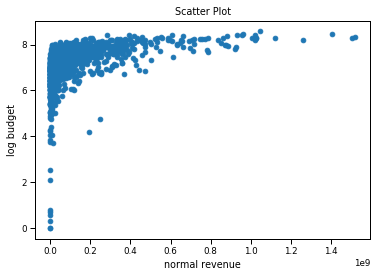

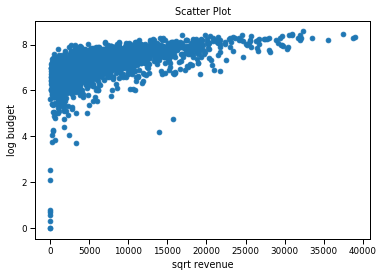

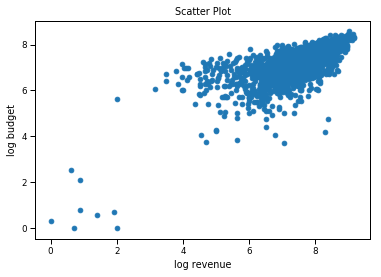

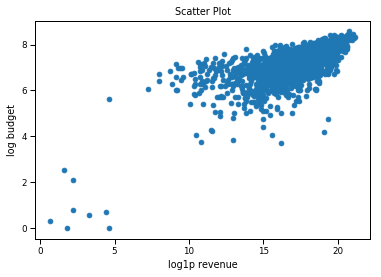

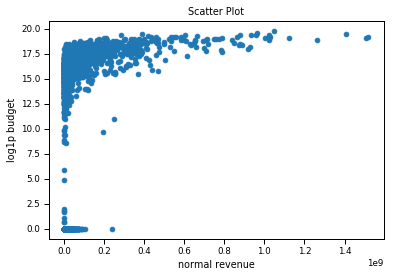

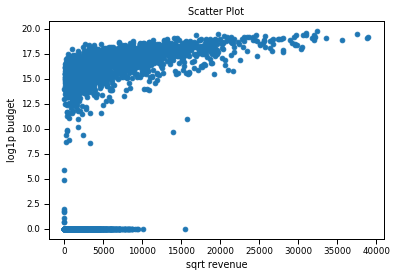

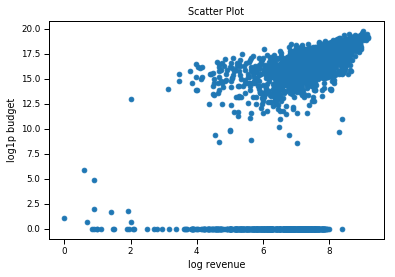

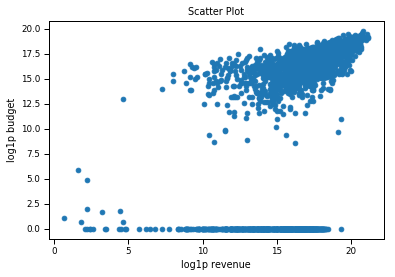

In [184]:
m=[np.array,np.sqrt,np.log10,np.log1p]
k = ['normal','sqrt','log','log1p']
count=0
def scatterplot(df):
    global count
    for i in range(0,len(m)):
        y = df[['budget']]
        y[['budget']] = m[i](y[['budget']])
        for j in range(0,len(m)):
            x = df[['revenue']].astype('float')
            x[['revenue']] = m[j](x[['revenue']])
            plt.scatter(x,y)
            count+=1
            plt.xlabel(k[j] +' revenue')
            plt.ylabel(k[i] +' budget')
            plt.title('Scatter Plot')
            plt.pause(0.005)

scatterplot(train)

In [185]:
train.shape

(2606, 21)

In [186]:
def budget_imputation(k):
    #####create model from values with budget!= 0 and revenue greater than 1000
    k1 = k.loc[(k['revenue'])>1000]
    main_data = k1.loc[(k1['budget'])!=0]
    
    ###test and training data
    traindata, testdata = train_test_split(main_data,test_size=.2, random_state=17)
    testdata.reset_index(drop=True, inplace=True)
    traindata.reset_index(drop=True, inplace=True)
    
    x = traindata.drop(['budget','id'],axis=1)
    x[['revenue']] = np.sqrt(x[['revenue']])
    xtest = testdata.drop(['budget','id'],axis=1)
    xtest[['revenue']] = np.sqrt(xtest[['revenue']])
    
    y = traindata[['budget']]
    y[['budget']] = np.sqrt(y[['budget']])
    ytest = testdata[['budget']]
    ytest[['budget']] = np.sqrt(ytest[['budget']])
    
    ####model
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100)
    model.fit(x, y)
    model.score(xtest,ytest)

    #####predict the values
    impute_data = k1.loc[(k1['budget'])==0]
    ximpute = impute_data.drop(['budget','id'],axis=1)
    ximpute[['revenue']] = np.sqrt(ximpute[['revenue']])
    ximpute.shape
    predict = model.predict(ximpute)
    predict[predict<0] = 0
    ximpute['budget'] = predict
    ximpute['budget'] = ximpute['budget'].apply(lambda x:x**2)
    k1.loc[(k1['budget'])==0,'budget'] = ximpute['budget']
    return k1
    

In [187]:
train = budget_imputation(train)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)


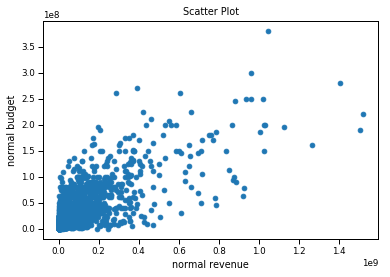

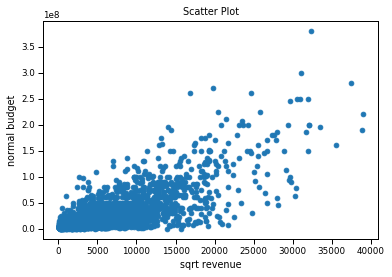

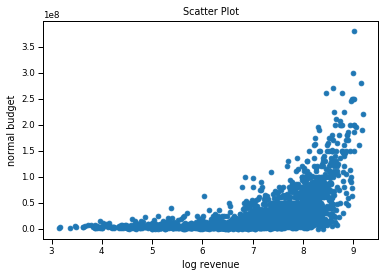

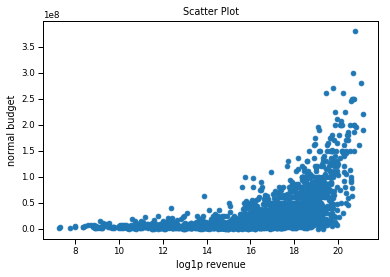

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


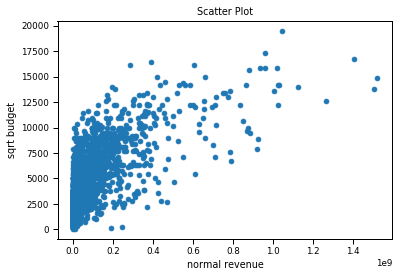

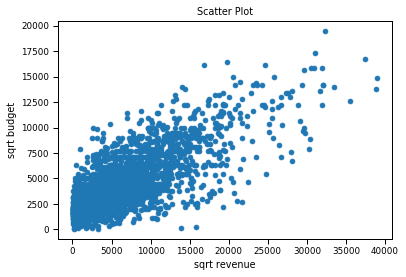

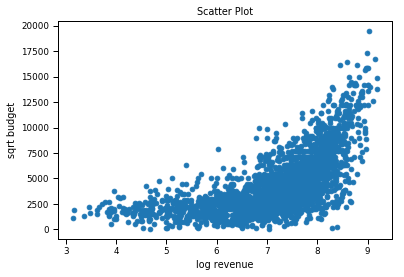

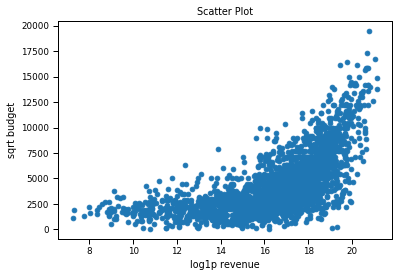

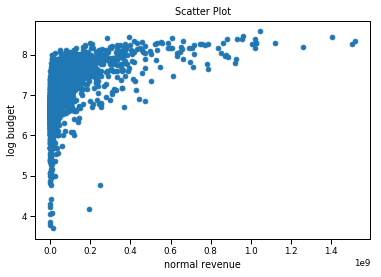

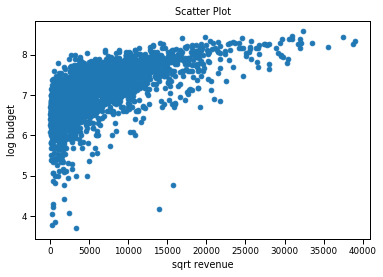

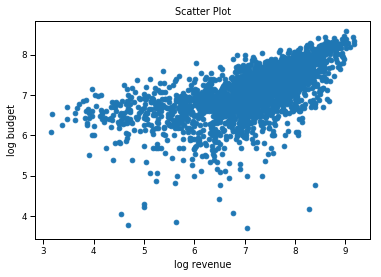

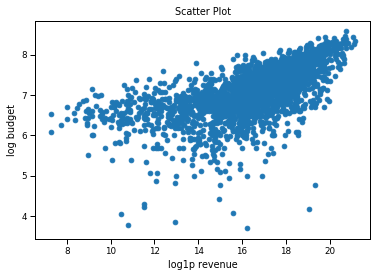

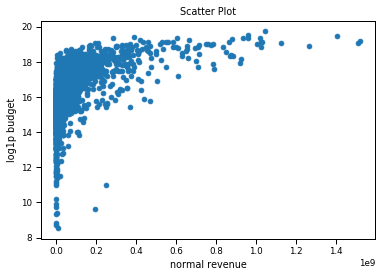

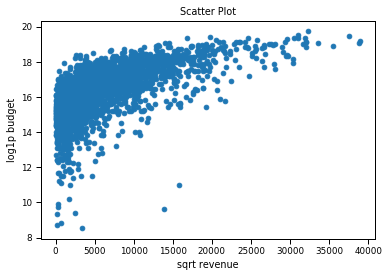

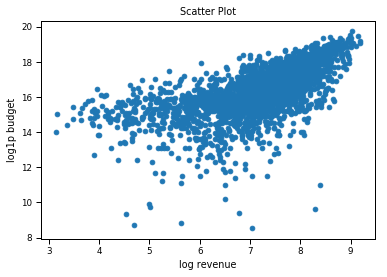

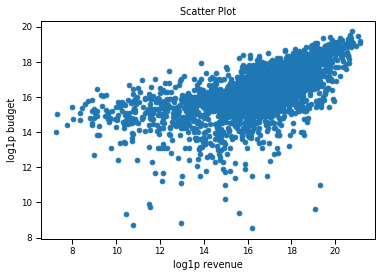

In [188]:
m=[np.array,np.sqrt,np.log10,np.log1p]
k = ['normal','sqrt','log','log1p']
count=0
def scatterplot(df):
    global count
    for i in range(0,len(m)):
        y = df[['budget']]
        y[['budget']] = m[i](y[['budget']])
        for j in range(0,len(m)):
            x = df[['revenue']].astype('float')
            x[['revenue']] = m[j](x[['revenue']])
            plt.scatter(x,y)
            count+=1
            plt.xlabel(k[j] +' revenue')
            plt.ylabel(k[i] +' budget')
            plt.title('Scatter Plot')
            plt.pause(0.005)

scatterplot(train)

### Main Model

In [189]:
traindata, testdata = train_test_split(train,test_size=.3, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

x_train = traindata.drop(['revenue','id'], axis=1)
y_train = traindata['revenue']
x_test = testdata.drop(['revenue','id'], axis=1)
y_test = testdata['revenue']

main_model= cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.7,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200)             
main_model.fit(x_train,y_train)
main_model.score(x_test,y_test)

Got unsafe target value = 1.01265e+07 at object #0 of dataset learn


0:	learn: 154724614.4022800	total: 4.03ms	remaining: 40.3s
1:	learn: 153810161.4135527	total: 7.96ms	remaining: 39.8s
2:	learn: 152997267.2079230	total: 11.2ms	remaining: 37.5s
3:	learn: 152166037.7137948	total: 14.2ms	remaining: 35.5s
4:	learn: 151333242.1953351	total: 17.3ms	remaining: 34.5s
5:	learn: 150489967.4861268	total: 20.3ms	remaining: 33.8s
6:	learn: 149598980.1696617	total: 23.2ms	remaining: 33.1s
7:	learn: 148818057.2155428	total: 26.2ms	remaining: 32.7s
8:	learn: 148035420.0956674	total: 29.7ms	remaining: 33s
9:	learn: 147247255.9429307	total: 32.8ms	remaining: 32.8s
10:	learn: 146464128.0767438	total: 36ms	remaining: 32.7s
11:	learn: 145701670.8906198	total: 39.2ms	remaining: 32.7s
12:	learn: 144923031.5354165	total: 42.7ms	remaining: 32.8s
13:	learn: 144140406.5384793	total: 45.6ms	remaining: 32.5s
14:	learn: 143453474.2758223	total: 48.2ms	remaining: 32.1s
15:	learn: 142709486.3705839	total: 51.1ms	remaining: 31.9s
16:	learn: 141967964.5005627	total: 53.9ms	remaining: 

189:	learn: 87197450.0323220	total: 582ms	remaining: 30.1s
190:	learn: 87103204.2606536	total: 585ms	remaining: 30s
191:	learn: 86999384.0180546	total: 588ms	remaining: 30s
192:	learn: 86928684.7388757	total: 591ms	remaining: 30s
193:	learn: 86831987.0886559	total: 594ms	remaining: 30s
194:	learn: 86718394.7035264	total: 597ms	remaining: 30s
195:	learn: 86616122.8747329	total: 600ms	remaining: 30s
196:	learn: 86525609.5040606	total: 603ms	remaining: 30s
197:	learn: 86443012.7710785	total: 606ms	remaining: 30s
198:	learn: 86348318.0249318	total: 609ms	remaining: 30s
199:	learn: 86251722.0684189	total: 612ms	remaining: 30s
200:	learn: 86185464.9510771	total: 615ms	remaining: 30s
201:	learn: 86120802.8206202	total: 618ms	remaining: 30s
202:	learn: 86039813.9084340	total: 620ms	remaining: 29.9s
203:	learn: 85974181.1789141	total: 623ms	remaining: 29.9s
204:	learn: 85874085.4959018	total: 628ms	remaining: 30s
205:	learn: 85770917.3351921	total: 632ms	remaining: 30s
206:	learn: 85696782.6014

382:	learn: 78420434.4208656	total: 1.15s	remaining: 28.9s
383:	learn: 78409246.0982818	total: 1.15s	remaining: 28.9s
384:	learn: 78372380.7476371	total: 1.16s	remaining: 28.9s
385:	learn: 78344356.3621887	total: 1.16s	remaining: 28.9s
386:	learn: 78297997.3751147	total: 1.16s	remaining: 28.9s
387:	learn: 78289571.2921486	total: 1.17s	remaining: 28.9s
388:	learn: 78263024.9448171	total: 1.17s	remaining: 28.9s
389:	learn: 78223903.2016564	total: 1.17s	remaining: 28.9s
390:	learn: 78199837.3057966	total: 1.18s	remaining: 28.9s
391:	learn: 78172912.9823339	total: 1.18s	remaining: 28.9s
392:	learn: 78152338.8038608	total: 1.18s	remaining: 28.9s
393:	learn: 78127022.8528176	total: 1.18s	remaining: 28.9s
394:	learn: 78118526.3449286	total: 1.19s	remaining: 28.9s
395:	learn: 78097376.5626900	total: 1.19s	remaining: 28.9s
396:	learn: 78079288.5899858	total: 1.19s	remaining: 28.9s
397:	learn: 78062146.9827507	total: 1.2s	remaining: 28.8s
398:	learn: 78046526.4733915	total: 1.2s	remaining: 28.8s

578:	learn: 75847902.7498034	total: 1.72s	remaining: 27.9s
579:	learn: 75830884.1460513	total: 1.72s	remaining: 27.9s
580:	learn: 75812737.2132615	total: 1.72s	remaining: 27.9s
581:	learn: 75788339.8477400	total: 1.72s	remaining: 27.9s
582:	learn: 75782298.0174408	total: 1.73s	remaining: 27.9s
583:	learn: 75775279.2629439	total: 1.73s	remaining: 27.9s
584:	learn: 75771101.0282574	total: 1.73s	remaining: 27.9s
585:	learn: 75759938.9567863	total: 1.74s	remaining: 27.9s
586:	learn: 75754298.9941114	total: 1.74s	remaining: 27.9s
587:	learn: 75748557.0021071	total: 1.74s	remaining: 27.9s
588:	learn: 75744498.6745217	total: 1.74s	remaining: 27.9s
589:	learn: 75744145.3451018	total: 1.75s	remaining: 27.9s
590:	learn: 75724735.3276386	total: 1.75s	remaining: 27.8s
591:	learn: 75723913.8420388	total: 1.75s	remaining: 27.8s
592:	learn: 75711315.2973373	total: 1.75s	remaining: 27.8s
593:	learn: 75690548.2193935	total: 1.76s	remaining: 27.8s
594:	learn: 75669360.0312044	total: 1.76s	remaining: 27.

783:	learn: 73869743.1292579	total: 2.27s	remaining: 26.7s
784:	learn: 73867856.8923143	total: 2.27s	remaining: 26.7s
785:	learn: 73836928.5557045	total: 2.28s	remaining: 26.7s
786:	learn: 73836032.4572945	total: 2.28s	remaining: 26.7s
787:	learn: 73829332.4344725	total: 2.28s	remaining: 26.7s
788:	learn: 73803347.1541501	total: 2.29s	remaining: 26.7s
789:	learn: 73775897.3316746	total: 2.29s	remaining: 26.7s
790:	learn: 73774144.2487441	total: 2.29s	remaining: 26.7s
791:	learn: 73760609.8136777	total: 2.29s	remaining: 26.7s
792:	learn: 73752069.3463750	total: 2.3s	remaining: 26.7s
793:	learn: 73725097.9962962	total: 2.3s	remaining: 26.7s
794:	learn: 73702269.1003310	total: 2.3s	remaining: 26.7s
795:	learn: 73701545.1959090	total: 2.31s	remaining: 26.7s
796:	learn: 73700626.6336448	total: 2.31s	remaining: 26.7s
797:	learn: 73699505.4603572	total: 2.31s	remaining: 26.6s
798:	learn: 73687586.7748047	total: 2.31s	remaining: 26.6s
799:	learn: 73686018.2611205	total: 2.32s	remaining: 26.6s


981:	learn: 72326645.0634857	total: 2.82s	remaining: 25.9s
982:	learn: 72312020.4622047	total: 2.83s	remaining: 25.9s
983:	learn: 72301359.0794825	total: 2.83s	remaining: 25.9s
984:	learn: 72269494.6526943	total: 2.83s	remaining: 25.9s
985:	learn: 72261678.3997864	total: 2.83s	remaining: 25.9s
986:	learn: 72260837.3972850	total: 2.84s	remaining: 25.9s
987:	learn: 72250949.7296222	total: 2.84s	remaining: 25.9s
988:	learn: 72250896.6716868	total: 2.84s	remaining: 25.9s
989:	learn: 72249041.0774698	total: 2.84s	remaining: 25.9s
990:	learn: 72248652.5801622	total: 2.85s	remaining: 25.9s
991:	learn: 72248481.6916082	total: 2.85s	remaining: 25.9s
992:	learn: 72236526.2716627	total: 2.85s	remaining: 25.9s
993:	learn: 72233300.4393163	total: 2.85s	remaining: 25.9s
994:	learn: 72233150.1224645	total: 2.86s	remaining: 25.9s
995:	learn: 72217936.3130369	total: 2.86s	remaining: 25.9s
996:	learn: 72207498.4874227	total: 2.86s	remaining: 25.9s
997:	learn: 72207293.2781822	total: 2.87s	remaining: 25.

1167:	learn: 70970056.6581471	total: 3.36s	remaining: 25.4s
1168:	learn: 70962729.9866155	total: 3.36s	remaining: 25.4s
1169:	learn: 70959711.7763963	total: 3.36s	remaining: 25.4s
1170:	learn: 70959689.4729546	total: 3.37s	remaining: 25.4s
1171:	learn: 70959597.4495723	total: 3.37s	remaining: 25.4s
1172:	learn: 70930132.4044723	total: 3.37s	remaining: 25.4s
1173:	learn: 70930017.6191499	total: 3.38s	remaining: 25.4s
1174:	learn: 70922231.7484696	total: 3.38s	remaining: 25.4s
1175:	learn: 70916691.0170585	total: 3.38s	remaining: 25.4s
1176:	learn: 70910311.9603073	total: 3.39s	remaining: 25.4s
1177:	learn: 70909761.5690487	total: 3.39s	remaining: 25.4s
1178:	learn: 70909741.9366462	total: 3.39s	remaining: 25.4s
1179:	learn: 70909629.3442916	total: 3.4s	remaining: 25.4s
1180:	learn: 70901898.7801709	total: 3.4s	remaining: 25.4s
1181:	learn: 70896971.9717288	total: 3.4s	remaining: 25.4s
1182:	learn: 70890380.1747627	total: 3.41s	remaining: 25.4s
1183:	learn: 70882190.0660967	total: 3.41s	

1355:	learn: 69962599.0619055	total: 3.9s	remaining: 24.8s
1356:	learn: 69961403.4010114	total: 3.9s	remaining: 24.8s
1357:	learn: 69960221.2428775	total: 3.9s	remaining: 24.8s
1358:	learn: 69952727.7805172	total: 3.91s	remaining: 24.8s
1359:	learn: 69921353.6422470	total: 3.91s	remaining: 24.8s
1360:	learn: 69921282.5110758	total: 3.91s	remaining: 24.8s
1361:	learn: 69917584.7172429	total: 3.91s	remaining: 24.8s
1362:	learn: 69913810.0940809	total: 3.92s	remaining: 24.8s
1363:	learn: 69908181.2958122	total: 3.92s	remaining: 24.8s
1364:	learn: 69907498.3353880	total: 3.92s	remaining: 24.8s
1365:	learn: 69897568.2847942	total: 3.92s	remaining: 24.8s
1366:	learn: 69894373.2091435	total: 3.93s	remaining: 24.8s
1367:	learn: 69894272.7518845	total: 3.93s	remaining: 24.8s
1368:	learn: 69892700.1155051	total: 3.93s	remaining: 24.8s
1369:	learn: 69885509.7954471	total: 3.94s	remaining: 24.8s
1370:	learn: 69880240.1717409	total: 3.94s	remaining: 24.8s
1371:	learn: 69875096.5370416	total: 3.94s	

1546:	learn: 68824165.1533882	total: 4.44s	remaining: 24.2s
1547:	learn: 68818881.3092149	total: 4.44s	remaining: 24.2s
1548:	learn: 68818816.1683609	total: 4.44s	remaining: 24.2s
1549:	learn: 68818728.0492633	total: 4.45s	remaining: 24.2s
1550:	learn: 68805569.8809056	total: 4.45s	remaining: 24.2s
1551:	learn: 68803755.4359453	total: 4.45s	remaining: 24.2s
1552:	learn: 68795385.7751448	total: 4.45s	remaining: 24.2s
1553:	learn: 68791448.2954312	total: 4.46s	remaining: 24.2s
1554:	learn: 68791385.6373167	total: 4.46s	remaining: 24.2s
1555:	learn: 68791181.5549572	total: 4.46s	remaining: 24.2s
1556:	learn: 68790689.1161727	total: 4.46s	remaining: 24.2s
1557:	learn: 68788288.8421923	total: 4.47s	remaining: 24.2s
1558:	learn: 68787484.3832216	total: 4.47s	remaining: 24.2s
1559:	learn: 68783805.7316180	total: 4.47s	remaining: 24.2s
1560:	learn: 68778844.9162595	total: 4.48s	remaining: 24.2s
1561:	learn: 68773572.4425785	total: 4.48s	remaining: 24.2s
1562:	learn: 68773524.4701109	total: 4.4

1740:	learn: 67850821.7348776	total: 4.97s	remaining: 23.6s
1741:	learn: 67850591.3667558	total: 4.97s	remaining: 23.6s
1742:	learn: 67849495.5919800	total: 4.97s	remaining: 23.6s
1743:	learn: 67847076.5808759	total: 4.98s	remaining: 23.6s
1744:	learn: 67835742.0142475	total: 4.98s	remaining: 23.6s
1745:	learn: 67831414.5646605	total: 4.99s	remaining: 23.6s
1746:	learn: 67824547.9758590	total: 4.99s	remaining: 23.6s
1747:	learn: 67809627.5238485	total: 4.99s	remaining: 23.6s
1748:	learn: 67807893.1208881	total: 4.99s	remaining: 23.6s
1749:	learn: 67807864.9654150	total: 5s	remaining: 23.6s
1750:	learn: 67803378.9488456	total: 5s	remaining: 23.5s
1751:	learn: 67800146.1734625	total: 5s	remaining: 23.5s
1752:	learn: 67799325.0075758	total: 5s	remaining: 23.5s
1753:	learn: 67799023.8800355	total: 5.01s	remaining: 23.5s
1754:	learn: 67789629.7196010	total: 5.01s	remaining: 23.5s
1755:	learn: 67780641.2220881	total: 5.01s	remaining: 23.5s
1756:	learn: 67772309.4586328	total: 5.02s	remaining

1926:	learn: 67072105.2204385	total: 5.49s	remaining: 23s
1927:	learn: 67072033.0244932	total: 5.5s	remaining: 23s
1928:	learn: 67071943.5238349	total: 5.5s	remaining: 23s
1929:	learn: 67065010.7043136	total: 5.5s	remaining: 23s
1930:	learn: 67064333.7472929	total: 5.5s	remaining: 23s
1931:	learn: 67040394.7489204	total: 5.5s	remaining: 23s
1932:	learn: 67037811.7613166	total: 5.51s	remaining: 23s
1933:	learn: 67037691.4591588	total: 5.51s	remaining: 23s
1934:	learn: 67035564.6274924	total: 5.51s	remaining: 23s
1935:	learn: 67035513.1245092	total: 5.52s	remaining: 23s
1936:	learn: 67035331.9512556	total: 5.52s	remaining: 23s
1937:	learn: 67030487.3752843	total: 5.52s	remaining: 23s
1938:	learn: 67030307.9209226	total: 5.52s	remaining: 23s
1939:	learn: 67030255.7746981	total: 5.53s	remaining: 23s
1940:	learn: 67029923.4131829	total: 5.53s	remaining: 23s
1941:	learn: 67029869.0894793	total: 5.53s	remaining: 23s
1942:	learn: 67029733.6343842	total: 5.53s	remaining: 23s
1943:	learn: 670204

2105:	learn: 66409839.3334787	total: 6s	remaining: 22.5s
2106:	learn: 66409698.8599976	total: 6s	remaining: 22.5s
2107:	learn: 66409564.3058314	total: 6s	remaining: 22.5s
2108:	learn: 66408902.8379890	total: 6.01s	remaining: 22.5s
2109:	learn: 66408875.5685460	total: 6.01s	remaining: 22.5s
2110:	learn: 66402480.2125111	total: 6.01s	remaining: 22.5s
2111:	learn: 66402356.9081165	total: 6.02s	remaining: 22.5s
2112:	learn: 66402329.9236632	total: 6.02s	remaining: 22.5s
2113:	learn: 66402199.5171939	total: 6.02s	remaining: 22.5s
2114:	learn: 66401966.2505113	total: 6.02s	remaining: 22.5s
2115:	learn: 66401939.6082037	total: 6.03s	remaining: 22.5s
2116:	learn: 66381101.8056249	total: 6.03s	remaining: 22.5s
2117:	learn: 66376308.1320245	total: 6.03s	remaining: 22.5s
2118:	learn: 66376182.9213473	total: 6.04s	remaining: 22.4s
2119:	learn: 66365274.3802899	total: 6.04s	remaining: 22.4s
2120:	learn: 66341558.5765250	total: 6.04s	remaining: 22.4s
2121:	learn: 66339336.6227470	total: 6.04s	remain

2290:	learn: 65687607.9710224	total: 6.5s	remaining: 21.9s
2291:	learn: 65687596.0208821	total: 6.5s	remaining: 21.9s
2292:	learn: 65687507.2490515	total: 6.5s	remaining: 21.9s
2293:	learn: 65687376.4334936	total: 6.5s	remaining: 21.9s
2294:	learn: 65685584.5416589	total: 6.51s	remaining: 21.9s
2295:	learn: 65683399.8733762	total: 6.51s	remaining: 21.8s
2296:	learn: 65683387.7784374	total: 6.51s	remaining: 21.8s
2297:	learn: 65681705.8647660	total: 6.51s	remaining: 21.8s
2298:	learn: 65679890.2525523	total: 6.52s	remaining: 21.8s
2299:	learn: 65667377.6586718	total: 6.52s	remaining: 21.8s
2300:	learn: 65667280.1523027	total: 6.52s	remaining: 21.8s
2301:	learn: 65660508.7694146	total: 6.53s	remaining: 21.8s
2302:	learn: 65649136.7510724	total: 6.53s	remaining: 21.8s
2303:	learn: 65649066.6884641	total: 6.53s	remaining: 21.8s
2304:	learn: 65649054.0843322	total: 6.53s	remaining: 21.8s
2305:	learn: 65648975.9488466	total: 6.54s	remaining: 21.8s
2306:	learn: 65646128.0072218	total: 6.54s	r

2475:	learn: 65189749.9992391	total: 6.99s	remaining: 21.3s
2476:	learn: 65189702.3712974	total: 7s	remaining: 21.2s
2477:	learn: 65189435.8484120	total: 7s	remaining: 21.2s
2478:	learn: 65186729.4192698	total: 7s	remaining: 21.2s
2479:	learn: 65186466.6321994	total: 7s	remaining: 21.2s
2480:	learn: 65186375.8004517	total: 7.01s	remaining: 21.2s
2481:	learn: 65186295.8240294	total: 7.01s	remaining: 21.2s
2482:	learn: 65180427.0579511	total: 7.01s	remaining: 21.2s
2483:	learn: 65179503.6462629	total: 7.01s	remaining: 21.2s
2484:	learn: 65179501.2789633	total: 7.02s	remaining: 21.2s
2485:	learn: 65174374.4928899	total: 7.02s	remaining: 21.2s
2486:	learn: 65174372.4311748	total: 7.02s	remaining: 21.2s
2487:	learn: 65167128.1711114	total: 7.02s	remaining: 21.2s
2488:	learn: 65166203.7220223	total: 7.03s	remaining: 21.2s
2489:	learn: 65165191.8734070	total: 7.03s	remaining: 21.2s
2490:	learn: 65165094.2508484	total: 7.03s	remaining: 21.2s
2491:	learn: 65165005.6474205	total: 7.04s	remaining

2654:	learn: 64870165.7470827	total: 7.48s	remaining: 20.7s
2655:	learn: 64867999.1932301	total: 7.49s	remaining: 20.7s
2656:	learn: 64860261.9811933	total: 7.49s	remaining: 20.7s
2657:	learn: 64860185.5588158	total: 7.49s	remaining: 20.7s
2658:	learn: 64854541.9454543	total: 7.49s	remaining: 20.7s
2659:	learn: 64853785.8468940	total: 7.5s	remaining: 20.7s
2660:	learn: 64853430.7778433	total: 7.5s	remaining: 20.7s
2661:	learn: 64853302.8099520	total: 7.5s	remaining: 20.7s
2662:	learn: 64853213.4710437	total: 7.5s	remaining: 20.7s
2663:	learn: 64853036.8626881	total: 7.51s	remaining: 20.7s
2664:	learn: 64852687.3527817	total: 7.51s	remaining: 20.7s
2665:	learn: 64841853.4598688	total: 7.51s	remaining: 20.7s
2666:	learn: 64841775.1649893	total: 7.52s	remaining: 20.7s
2667:	learn: 64832644.4277396	total: 7.52s	remaining: 20.7s
2668:	learn: 64832575.9647561	total: 7.52s	remaining: 20.7s
2669:	learn: 64832501.4444510	total: 7.53s	remaining: 20.7s
2670:	learn: 64832121.2299915	total: 7.53s	r

2822:	learn: 64454629.4762430	total: 7.96s	remaining: 20.2s
2823:	learn: 64454491.4968655	total: 7.96s	remaining: 20.2s
2824:	learn: 64454491.4766068	total: 7.96s	remaining: 20.2s
2825:	learn: 64454057.3476088	total: 7.96s	remaining: 20.2s
2826:	learn: 64453485.5408594	total: 7.97s	remaining: 20.2s
2827:	learn: 64453448.9936889	total: 7.97s	remaining: 20.2s
2828:	learn: 64436521.8715881	total: 7.97s	remaining: 20.2s
2829:	learn: 64436485.4846949	total: 7.97s	remaining: 20.2s
2830:	learn: 64435648.4542690	total: 7.98s	remaining: 20.2s
2831:	learn: 64435380.9586245	total: 7.98s	remaining: 20.2s
2832:	learn: 64435341.4986597	total: 7.98s	remaining: 20.2s
2833:	learn: 64435266.1493104	total: 7.99s	remaining: 20.2s
2834:	learn: 64432445.7074714	total: 7.99s	remaining: 20.2s
2835:	learn: 64432224.6733362	total: 7.99s	remaining: 20.2s
2836:	learn: 64432093.5783946	total: 8s	remaining: 20.2s
2837:	learn: 64427492.9094246	total: 8s	remaining: 20.2s
2838:	learn: 64426974.2587558	total: 8s	remain

2993:	learn: 64196664.7372870	total: 8.43s	remaining: 19.7s
2994:	learn: 64184487.1568984	total: 8.44s	remaining: 19.7s
2995:	learn: 64184278.8856901	total: 8.44s	remaining: 19.7s
2996:	learn: 64184074.4039533	total: 8.44s	remaining: 19.7s
2997:	learn: 64184045.1044372	total: 8.44s	remaining: 19.7s
2998:	learn: 64184017.0214705	total: 8.45s	remaining: 19.7s
2999:	learn: 64183746.7375716	total: 8.45s	remaining: 19.7s
3000:	learn: 64177673.5597641	total: 8.45s	remaining: 19.7s
3001:	learn: 64177643.7542496	total: 8.45s	remaining: 19.7s
3002:	learn: 64177615.3165290	total: 8.46s	remaining: 19.7s
3003:	learn: 64177586.6685295	total: 8.46s	remaining: 19.7s
3004:	learn: 64177295.5680501	total: 8.46s	remaining: 19.7s
3005:	learn: 64176997.9782668	total: 8.46s	remaining: 19.7s
3006:	learn: 64176904.6287983	total: 8.47s	remaining: 19.7s
3007:	learn: 64176875.3557409	total: 8.47s	remaining: 19.7s
3008:	learn: 64176779.4377278	total: 8.47s	remaining: 19.7s
3009:	learn: 64168503.0987612	total: 8.4

3157:	learn: 63866577.8363918	total: 8.9s	remaining: 19.3s
3158:	learn: 63855675.3867256	total: 8.91s	remaining: 19.3s
3159:	learn: 63855611.0298549	total: 8.91s	remaining: 19.3s
3160:	learn: 63842345.0602028	total: 8.91s	remaining: 19.3s
3161:	learn: 63835907.9217873	total: 8.91s	remaining: 19.3s
3162:	learn: 63835824.3925477	total: 8.92s	remaining: 19.3s
3163:	learn: 63828419.7718460	total: 8.92s	remaining: 19.3s
3164:	learn: 63828218.9127442	total: 8.92s	remaining: 19.3s
3165:	learn: 63828153.0629292	total: 8.93s	remaining: 19.3s
3166:	learn: 63821797.2994756	total: 8.93s	remaining: 19.3s
3167:	learn: 63821575.7666432	total: 8.93s	remaining: 19.3s
3168:	learn: 63821551.2421754	total: 8.94s	remaining: 19.3s
3169:	learn: 63821354.8716473	total: 8.94s	remaining: 19.3s
3170:	learn: 63820981.7058602	total: 8.94s	remaining: 19.3s
3171:	learn: 63820619.6206717	total: 8.94s	remaining: 19.3s
3172:	learn: 63820247.6219503	total: 8.95s	remaining: 19.3s
3173:	learn: 63820032.8574088	total: 8.95

3318:	learn: 63487136.7471863	total: 9.37s	remaining: 18.9s
3319:	learn: 63486861.4310320	total: 9.37s	remaining: 18.9s
3320:	learn: 63486843.0983745	total: 9.37s	remaining: 18.9s
3321:	learn: 63486597.4868373	total: 9.38s	remaining: 18.9s
3322:	learn: 63486467.3692561	total: 9.38s	remaining: 18.8s
3323:	learn: 63486413.3000735	total: 9.38s	remaining: 18.8s
3324:	learn: 63486351.7171938	total: 9.38s	remaining: 18.8s
3325:	learn: 63486081.1775860	total: 9.39s	remaining: 18.8s
3326:	learn: 63470973.5284523	total: 9.39s	remaining: 18.8s
3327:	learn: 63470918.2118154	total: 9.39s	remaining: 18.8s
3328:	learn: 63465675.1194473	total: 9.39s	remaining: 18.8s
3329:	learn: 63463727.6407065	total: 9.4s	remaining: 18.8s
3330:	learn: 63449114.7333213	total: 9.4s	remaining: 18.8s
3331:	learn: 63448881.5535585	total: 9.4s	remaining: 18.8s
3332:	learn: 63446463.7381880	total: 9.41s	remaining: 18.8s
3333:	learn: 63445968.8079771	total: 9.41s	remaining: 18.8s
3334:	learn: 63445895.7033431	total: 9.41s	

3494:	learn: 63122764.8536760	total: 9.86s	remaining: 18.3s
3495:	learn: 63122139.6433623	total: 9.86s	remaining: 18.3s
3496:	learn: 63121523.0266410	total: 9.86s	remaining: 18.3s
3497:	learn: 63105465.3414380	total: 9.86s	remaining: 18.3s
3498:	learn: 63105375.0086825	total: 9.87s	remaining: 18.3s
3499:	learn: 63105158.7529938	total: 9.87s	remaining: 18.3s
3500:	learn: 63105106.0490652	total: 9.87s	remaining: 18.3s
3501:	learn: 63104835.0224624	total: 9.88s	remaining: 18.3s
3502:	learn: 63104823.9976122	total: 9.88s	remaining: 18.3s
3503:	learn: 63104552.5429380	total: 9.88s	remaining: 18.3s
3504:	learn: 63104339.3089802	total: 9.88s	remaining: 18.3s
3505:	learn: 63098421.5715838	total: 9.89s	remaining: 18.3s
3506:	learn: 63098154.4192987	total: 9.89s	remaining: 18.3s
3507:	learn: 63098126.9541414	total: 9.89s	remaining: 18.3s
3508:	learn: 63098073.2666578	total: 9.89s	remaining: 18.3s
3509:	learn: 63093573.9061821	total: 9.9s	remaining: 18.3s
3510:	learn: 63088723.3308395	total: 9.9s

3665:	learn: 62687975.3604091	total: 10.3s	remaining: 17.8s
3666:	learn: 62686814.1363827	total: 10.3s	remaining: 17.8s
3667:	learn: 62681702.4212528	total: 10.3s	remaining: 17.8s
3668:	learn: 62681632.2286581	total: 10.3s	remaining: 17.8s
3669:	learn: 62681573.9912853	total: 10.3s	remaining: 17.8s
3670:	learn: 62675857.5346025	total: 10.3s	remaining: 17.8s
3671:	learn: 62675700.3357522	total: 10.3s	remaining: 17.8s
3672:	learn: 62675628.9783552	total: 10.3s	remaining: 17.8s
3673:	learn: 62674849.2965512	total: 10.4s	remaining: 17.8s
3674:	learn: 62673645.1967281	total: 10.4s	remaining: 17.8s
3675:	learn: 62673613.7833657	total: 10.4s	remaining: 17.8s
3676:	learn: 62673542.9244537	total: 10.4s	remaining: 17.8s
3677:	learn: 62665739.0275308	total: 10.4s	remaining: 17.8s
3678:	learn: 62665585.3486829	total: 10.4s	remaining: 17.8s
3679:	learn: 62665485.2486241	total: 10.4s	remaining: 17.8s
3680:	learn: 62663809.6459358	total: 10.4s	remaining: 17.8s
3681:	learn: 62655958.1840726	total: 10.

3824:	learn: 62322045.6567979	total: 10.8s	remaining: 17.4s
3825:	learn: 62321992.5047713	total: 10.8s	remaining: 17.4s
3826:	learn: 62321379.3869717	total: 10.8s	remaining: 17.4s
3827:	learn: 62320765.5101596	total: 10.8s	remaining: 17.4s
3828:	learn: 62320179.9084939	total: 10.8s	remaining: 17.4s
3829:	learn: 62320130.1446034	total: 10.8s	remaining: 17.4s
3830:	learn: 62319550.2255957	total: 10.8s	remaining: 17.4s
3831:	learn: 62319520.2920052	total: 10.8s	remaining: 17.4s
3832:	learn: 62309910.8354239	total: 10.8s	remaining: 17.4s
3833:	learn: 62309332.0869009	total: 10.8s	remaining: 17.4s
3834:	learn: 62309307.9335385	total: 10.8s	remaining: 17.4s
3835:	learn: 62300822.2156057	total: 10.8s	remaining: 17.4s
3836:	learn: 62300792.1194307	total: 10.8s	remaining: 17.4s
3837:	learn: 62282652.8499228	total: 10.8s	remaining: 17.4s
3838:	learn: 62282603.6863662	total: 10.8s	remaining: 17.4s
3839:	learn: 62282070.1515181	total: 10.8s	remaining: 17.4s
3840:	learn: 62282018.1322152	total: 10.

3972:	learn: 62036607.0924567	total: 11.2s	remaining: 17s
3973:	learn: 62036558.3025267	total: 11.2s	remaining: 17s
3974:	learn: 62035220.8791956	total: 11.2s	remaining: 17s
3975:	learn: 62029452.7336522	total: 11.2s	remaining: 17s
3976:	learn: 62029413.6762093	total: 11.2s	remaining: 17s
3977:	learn: 62028962.1677545	total: 11.2s	remaining: 17s
3978:	learn: 62028941.3655386	total: 11.2s	remaining: 17s
3979:	learn: 62028902.8095565	total: 11.2s	remaining: 17s
3980:	learn: 62028885.9776838	total: 11.2s	remaining: 17s
3981:	learn: 62019288.5100201	total: 11.2s	remaining: 17s
3982:	learn: 62018857.7833764	total: 11.2s	remaining: 17s
3983:	learn: 62018432.8077301	total: 11.2s	remaining: 17s
3984:	learn: 62012097.9831404	total: 11.2s	remaining: 17s
3985:	learn: 62003998.0408342	total: 11.2s	remaining: 17s
3986:	learn: 62003130.9998684	total: 11.3s	remaining: 17s
3987:	learn: 62003092.3537548	total: 11.3s	remaining: 17s
3988:	learn: 62003031.8671378	total: 11.3s	remaining: 17s
3989:	learn: 6

4113:	learn: 61761089.6915520	total: 11.6s	remaining: 16.6s
4114:	learn: 61751167.1795992	total: 11.6s	remaining: 16.6s
4115:	learn: 61750650.7272315	total: 11.6s	remaining: 16.6s
4116:	learn: 61746057.8335540	total: 11.6s	remaining: 16.6s
4117:	learn: 61745750.5672988	total: 11.6s	remaining: 16.6s
4118:	learn: 61745632.3229840	total: 11.6s	remaining: 16.6s
4119:	learn: 61745133.6676348	total: 11.6s	remaining: 16.6s
4120:	learn: 61745114.6200299	total: 11.6s	remaining: 16.6s
4121:	learn: 61744811.0830723	total: 11.6s	remaining: 16.6s
4122:	learn: 61744770.1620625	total: 11.6s	remaining: 16.6s
4123:	learn: 61744474.1009454	total: 11.6s	remaining: 16.6s
4124:	learn: 61744433.7454532	total: 11.7s	remaining: 16.6s
4125:	learn: 61744373.5862407	total: 11.7s	remaining: 16.6s
4126:	learn: 61731894.3001496	total: 11.7s	remaining: 16.6s
4127:	learn: 61731731.5620229	total: 11.7s	remaining: 16.6s
4128:	learn: 61731672.2162838	total: 11.7s	remaining: 16.6s
4129:	learn: 61731636.3532741	total: 11.

4295:	learn: 61485151.9639297	total: 12.2s	remaining: 16.2s
4296:	learn: 61485117.0557808	total: 12.2s	remaining: 16.2s
4297:	learn: 61476546.8528034	total: 12.2s	remaining: 16.2s
4298:	learn: 61476445.0848159	total: 12.2s	remaining: 16.2s
4299:	learn: 61476320.0316982	total: 12.2s	remaining: 16.2s
4300:	learn: 61463269.3708674	total: 12.2s	remaining: 16.2s
4301:	learn: 61463133.0124122	total: 12.2s	remaining: 16.1s
4302:	learn: 61458246.3666181	total: 12.2s	remaining: 16.1s
4303:	learn: 61458199.8573265	total: 12.2s	remaining: 16.1s
4304:	learn: 61453385.0628785	total: 12.2s	remaining: 16.1s
4305:	learn: 61453203.5782277	total: 12.2s	remaining: 16.1s
4306:	learn: 61453024.5797448	total: 12.2s	remaining: 16.1s
4307:	learn: 61452443.0492461	total: 12.2s	remaining: 16.1s
4308:	learn: 61452260.2040758	total: 12.2s	remaining: 16.1s
4309:	learn: 61452079.9166297	total: 12.2s	remaining: 16.1s
4310:	learn: 61438867.2551288	total: 12.2s	remaining: 16.1s
4311:	learn: 61423919.0334637	total: 12.

4438:	learn: 61182670.9768110	total: 12.6s	remaining: 15.8s
4439:	learn: 61182590.5922965	total: 12.6s	remaining: 15.8s
4440:	learn: 61179107.1035471	total: 12.6s	remaining: 15.8s
4441:	learn: 61178975.6440352	total: 12.6s	remaining: 15.8s
4442:	learn: 61178892.4566652	total: 12.6s	remaining: 15.8s
4443:	learn: 61178873.7803391	total: 12.6s	remaining: 15.8s
4444:	learn: 61178748.8094836	total: 12.6s	remaining: 15.8s
4445:	learn: 61173400.7695274	total: 12.6s	remaining: 15.7s
4446:	learn: 61173266.1457181	total: 12.6s	remaining: 15.7s
4447:	learn: 61173126.5041854	total: 12.6s	remaining: 15.7s
4448:	learn: 61173116.6307879	total: 12.6s	remaining: 15.7s
4449:	learn: 61169087.5944243	total: 12.6s	remaining: 15.7s
4450:	learn: 61169063.3135427	total: 12.6s	remaining: 15.7s
4451:	learn: 61168922.9496847	total: 12.6s	remaining: 15.7s
4452:	learn: 61155464.3941916	total: 12.6s	remaining: 15.7s
4453:	learn: 61155438.5856941	total: 12.6s	remaining: 15.7s
4454:	learn: 61155359.4655444	total: 12.

4582:	learn: 60877258.9625951	total: 13s	remaining: 15.4s
4583:	learn: 60876646.0803759	total: 13s	remaining: 15.4s
4584:	learn: 60875877.7417260	total: 13s	remaining: 15.4s
4585:	learn: 60875474.0220408	total: 13s	remaining: 15.4s
4586:	learn: 60870140.8079519	total: 13s	remaining: 15.4s
4587:	learn: 60870074.0948755	total: 13s	remaining: 15.3s
4588:	learn: 60869552.2698561	total: 13s	remaining: 15.3s
4589:	learn: 60869529.8096935	total: 13s	remaining: 15.3s
4590:	learn: 60869503.9732826	total: 13s	remaining: 15.3s
4591:	learn: 60869130.2633590	total: 13s	remaining: 15.3s
4592:	learn: 60865191.1685137	total: 13s	remaining: 15.3s
4593:	learn: 60864532.5713884	total: 13s	remaining: 15.3s
4594:	learn: 60864467.5934888	total: 13s	remaining: 15.3s
4595:	learn: 60864404.7415918	total: 13s	remaining: 15.3s
4596:	learn: 60864342.2343210	total: 13s	remaining: 15.3s
4597:	learn: 60863351.5678614	total: 13s	remaining: 15.3s
4598:	learn: 60852833.2822986	total: 13s	remaining: 15.3s
4599:	learn: 6

4763:	learn: 60516747.6293925	total: 13.5s	remaining: 14.9s
4764:	learn: 60510657.9306151	total: 13.5s	remaining: 14.9s
4765:	learn: 60510411.3097890	total: 13.5s	remaining: 14.9s
4766:	learn: 60510351.1749702	total: 13.5s	remaining: 14.9s
4767:	learn: 60509968.6941367	total: 13.5s	remaining: 14.9s
4768:	learn: 60509910.2930802	total: 13.6s	remaining: 14.9s
4769:	learn: 60508990.4058187	total: 13.6s	remaining: 14.9s
4770:	learn: 60507947.1039037	total: 13.6s	remaining: 14.9s
4771:	learn: 60507924.3138215	total: 13.6s	remaining: 14.9s
4772:	learn: 60498023.2946403	total: 13.6s	remaining: 14.9s
4773:	learn: 60494454.6718749	total: 13.6s	remaining: 14.9s
4774:	learn: 60493944.2449649	total: 13.6s	remaining: 14.8s
4775:	learn: 60479735.2124518	total: 13.6s	remaining: 14.8s
4776:	learn: 60479674.6650514	total: 13.6s	remaining: 14.8s
4777:	learn: 60479331.1465165	total: 13.6s	remaining: 14.8s
4778:	learn: 60478688.2417666	total: 13.6s	remaining: 14.8s
4779:	learn: 60470084.6008173	total: 13.

4942:	learn: 60039582.0270001	total: 14.1s	remaining: 14.4s
4943:	learn: 60039251.2135093	total: 14.1s	remaining: 14.4s
4944:	learn: 60038905.3759235	total: 14.1s	remaining: 14.4s
4945:	learn: 60037410.8248191	total: 14.1s	remaining: 14.4s
4946:	learn: 60028952.8713257	total: 14.1s	remaining: 14.4s
4947:	learn: 60028767.2322283	total: 14.1s	remaining: 14.4s
4948:	learn: 60028703.0970535	total: 14.1s	remaining: 14.4s
4949:	learn: 60028551.4097109	total: 14.1s	remaining: 14.4s
4950:	learn: 60028205.5039067	total: 14.1s	remaining: 14.4s
4951:	learn: 60028194.6243002	total: 14.1s	remaining: 14.4s
4952:	learn: 60028182.9744681	total: 14.1s	remaining: 14.4s
4953:	learn: 60028182.1545925	total: 14.1s	remaining: 14.4s
4954:	learn: 60026919.2111744	total: 14.1s	remaining: 14.4s
4955:	learn: 60026855.4976880	total: 14.1s	remaining: 14.4s
4956:	learn: 60026854.0103869	total: 14.1s	remaining: 14.4s
4957:	learn: 60026852.5470937	total: 14.1s	remaining: 14.4s
4958:	learn: 60026791.8863881	total: 14.

5090:	learn: 59782279.5259684	total: 14.5s	remaining: 14s
5091:	learn: 59781614.5052029	total: 14.5s	remaining: 14s
5092:	learn: 59777084.7184404	total: 14.5s	remaining: 14s
5093:	learn: 59776497.6982569	total: 14.5s	remaining: 14s
5094:	learn: 59775880.4575837	total: 14.5s	remaining: 14s
5095:	learn: 59775867.6369917	total: 14.5s	remaining: 14s
5096:	learn: 59775708.4295726	total: 14.5s	remaining: 14s
5097:	learn: 59775707.6058682	total: 14.5s	remaining: 14s
5098:	learn: 59775705.5162345	total: 14.5s	remaining: 14s
5099:	learn: 59775701.9835476	total: 14.5s	remaining: 14s
5100:	learn: 59765744.2106751	total: 14.6s	remaining: 14s
5101:	learn: 59765139.0741059	total: 14.6s	remaining: 14s
5102:	learn: 59754007.2548952	total: 14.6s	remaining: 14s
5103:	learn: 59750395.9058872	total: 14.6s	remaining: 14s
5104:	learn: 59742114.5484802	total: 14.6s	remaining: 14s
5105:	learn: 59741524.4714981	total: 14.6s	remaining: 14s
5106:	learn: 59740943.9011126	total: 14.6s	remaining: 14s
5107:	learn: 5

5239:	learn: 59557732.3419259	total: 14.9s	remaining: 13.6s
5240:	learn: 59552877.7337568	total: 14.9s	remaining: 13.6s
5241:	learn: 59542045.1233368	total: 14.9s	remaining: 13.6s
5242:	learn: 59541278.8990313	total: 15s	remaining: 13.6s
5243:	learn: 59541116.2406749	total: 15s	remaining: 13.6s
5244:	learn: 59541045.8052420	total: 15s	remaining: 13.6s
5245:	learn: 59540985.1740762	total: 15s	remaining: 13.6s
5246:	learn: 59540427.6023023	total: 15s	remaining: 13.6s
5247:	learn: 59540409.3138431	total: 15s	remaining: 13.6s
5248:	learn: 59540354.7951704	total: 15s	remaining: 13.6s
5249:	learn: 59536152.6980714	total: 15s	remaining: 13.5s
5250:	learn: 59536098.6811364	total: 15s	remaining: 13.5s
5251:	learn: 59534824.6830552	total: 15s	remaining: 13.5s
5252:	learn: 59534657.1767685	total: 15s	remaining: 13.5s
5253:	learn: 59533515.6262393	total: 15s	remaining: 13.5s
5254:	learn: 59533200.9447635	total: 15s	remaining: 13.5s
5255:	learn: 59533054.1276801	total: 15s	remaining: 13.5s
5256:	le

5381:	learn: 59183463.2097296	total: 15.4s	remaining: 13.2s
5382:	learn: 59183399.8555173	total: 15.4s	remaining: 13.2s
5383:	learn: 59181047.2358697	total: 15.4s	remaining: 13.2s
5384:	learn: 59173660.0363503	total: 15.4s	remaining: 13.2s
5385:	learn: 59173639.2700714	total: 15.4s	remaining: 13.2s
5386:	learn: 59170362.5694912	total: 15.4s	remaining: 13.2s
5387:	learn: 59170308.7168191	total: 15.4s	remaining: 13.2s
5388:	learn: 59170307.0774645	total: 15.4s	remaining: 13.2s
5389:	learn: 59170021.5913545	total: 15.4s	remaining: 13.2s
5390:	learn: 59169968.3775735	total: 15.4s	remaining: 13.1s
5391:	learn: 59169467.5963546	total: 15.4s	remaining: 13.1s
5392:	learn: 59169268.1166685	total: 15.4s	remaining: 13.1s
5393:	learn: 59169215.3332032	total: 15.4s	remaining: 13.1s
5394:	learn: 59147117.8449501	total: 15.4s	remaining: 13.1s
5395:	learn: 59134566.7987525	total: 15.4s	remaining: 13.1s
5396:	learn: 59134504.1002784	total: 15.4s	remaining: 13.1s
5397:	learn: 59134305.8570947	total: 15.

5521:	learn: 58917364.2446102	total: 15.8s	remaining: 12.8s
5522:	learn: 58909937.9824606	total: 15.8s	remaining: 12.8s
5523:	learn: 58909834.3505664	total: 15.8s	remaining: 12.8s
5524:	learn: 58909806.9297692	total: 15.8s	remaining: 12.8s
5525:	learn: 58909772.2543895	total: 15.8s	remaining: 12.8s
5526:	learn: 58909754.7398481	total: 15.8s	remaining: 12.8s
5527:	learn: 58909737.3858352	total: 15.8s	remaining: 12.8s
5528:	learn: 58909727.2055822	total: 15.8s	remaining: 12.8s
5529:	learn: 58909690.5745788	total: 15.8s	remaining: 12.8s
5530:	learn: 58909688.7920794	total: 15.8s	remaining: 12.8s
5531:	learn: 58908569.9482848	total: 15.8s	remaining: 12.8s
5532:	learn: 58908473.1601334	total: 15.8s	remaining: 12.8s
5533:	learn: 58908385.2461945	total: 15.8s	remaining: 12.7s
5534:	learn: 58908375.1482610	total: 15.8s	remaining: 12.7s
5535:	learn: 58908276.6967467	total: 15.8s	remaining: 12.7s
5536:	learn: 58908272.0771058	total: 15.8s	remaining: 12.7s
5537:	learn: 58908233.8050827	total: 15.

5705:	learn: 58619529.3351490	total: 16.3s	remaining: 12.3s
5706:	learn: 58619527.4721286	total: 16.3s	remaining: 12.3s
5707:	learn: 58618286.8900009	total: 16.3s	remaining: 12.3s
5708:	learn: 58618284.4315143	total: 16.3s	remaining: 12.3s
5709:	learn: 58604122.9005909	total: 16.3s	remaining: 12.2s
5710:	learn: 58604120.9493213	total: 16.3s	remaining: 12.2s
5711:	learn: 58604120.1282982	total: 16.3s	remaining: 12.2s
5712:	learn: 58604117.3107226	total: 16.3s	remaining: 12.2s
5713:	learn: 58603296.0852078	total: 16.3s	remaining: 12.2s
5714:	learn: 58603273.9817496	total: 16.3s	remaining: 12.2s
5715:	learn: 58567975.1583973	total: 16.3s	remaining: 12.2s
5716:	learn: 58566416.6484267	total: 16.3s	remaining: 12.2s
5717:	learn: 58563671.8327352	total: 16.3s	remaining: 12.2s
5718:	learn: 58562708.8366639	total: 16.3s	remaining: 12.2s
5719:	learn: 58562695.6222810	total: 16.3s	remaining: 12.2s
5720:	learn: 58562692.9183207	total: 16.3s	remaining: 12.2s
5721:	learn: 58558131.2906446	total: 16.

5882:	learn: 58235708.3310677	total: 16.8s	remaining: 11.8s
5883:	learn: 58235661.2464803	total: 16.8s	remaining: 11.8s
5884:	learn: 58234026.8619724	total: 16.8s	remaining: 11.8s
5885:	learn: 58234026.0408421	total: 16.8s	remaining: 11.8s
5886:	learn: 58230046.1296122	total: 16.8s	remaining: 11.8s
5887:	learn: 58230045.6091391	total: 16.8s	remaining: 11.7s
5888:	learn: 58230031.3156272	total: 16.8s	remaining: 11.7s
5889:	learn: 58229917.8655683	total: 16.8s	remaining: 11.7s
5890:	learn: 58227700.7280975	total: 16.8s	remaining: 11.7s
5891:	learn: 58221856.8389912	total: 16.8s	remaining: 11.7s
5892:	learn: 58221856.0567059	total: 16.8s	remaining: 11.7s
5893:	learn: 58221010.2888523	total: 16.8s	remaining: 11.7s
5894:	learn: 58220963.8608157	total: 16.8s	remaining: 11.7s
5895:	learn: 58220034.3696612	total: 16.8s	remaining: 11.7s
5896:	learn: 58220028.3865330	total: 16.8s	remaining: 11.7s
5897:	learn: 58219975.0441255	total: 16.9s	remaining: 11.7s
5898:	learn: 58219959.6421845	total: 16.

6057:	learn: 57965948.6476179	total: 17.3s	remaining: 11.3s
6058:	learn: 57965902.1443342	total: 17.3s	remaining: 11.3s
6059:	learn: 57965897.8634295	total: 17.3s	remaining: 11.3s
6060:	learn: 57965884.7381933	total: 17.3s	remaining: 11.3s
6061:	learn: 57965838.7685438	total: 17.3s	remaining: 11.3s
6062:	learn: 57965788.9093756	total: 17.3s	remaining: 11.3s
6063:	learn: 57965216.5798975	total: 17.3s	remaining: 11.3s
6064:	learn: 57965214.5959063	total: 17.3s	remaining: 11.2s
6065:	learn: 57958890.6223024	total: 17.3s	remaining: 11.2s
6066:	learn: 57958853.3792080	total: 17.3s	remaining: 11.2s
6067:	learn: 57958845.6177904	total: 17.3s	remaining: 11.2s
6068:	learn: 57958843.6365569	total: 17.3s	remaining: 11.2s
6069:	learn: 57953231.0278339	total: 17.4s	remaining: 11.2s
6070:	learn: 57952792.9452585	total: 17.4s	remaining: 11.2s
6071:	learn: 57952790.9945580	total: 17.4s	remaining: 11.2s
6072:	learn: 57948470.2284186	total: 17.4s	remaining: 11.2s
6073:	learn: 57948468.2563488	total: 17.

6197:	learn: 57759072.3293326	total: 17.7s	remaining: 10.9s
6198:	learn: 57759067.4592320	total: 17.7s	remaining: 10.9s
6199:	learn: 57759057.6021478	total: 17.7s	remaining: 10.9s
6200:	learn: 57759056.3498087	total: 17.7s	remaining: 10.9s
6201:	learn: 57758890.9217734	total: 17.7s	remaining: 10.9s
6202:	learn: 57747352.2984551	total: 17.7s	remaining: 10.8s
6203:	learn: 57746536.3969519	total: 17.7s	remaining: 10.8s
6204:	learn: 57746526.6075934	total: 17.7s	remaining: 10.8s
6205:	learn: 57746473.5168584	total: 17.7s	remaining: 10.8s
6206:	learn: 57745693.1596210	total: 17.7s	remaining: 10.8s
6207:	learn: 57745683.5050298	total: 17.7s	remaining: 10.8s
6208:	learn: 57745515.2267738	total: 17.7s	remaining: 10.8s
6209:	learn: 57745505.6701453	total: 17.7s	remaining: 10.8s
6210:	learn: 57745496.0675387	total: 17.7s	remaining: 10.8s
6211:	learn: 57742705.6308461	total: 17.8s	remaining: 10.8s
6212:	learn: 57742051.2630756	total: 17.8s	remaining: 10.8s
6213:	learn: 57741583.8242292	total: 17.

6378:	learn: 57526089.6349876	total: 18.2s	remaining: 10.4s
6379:	learn: 57526059.9094481	total: 18.2s	remaining: 10.3s
6380:	learn: 57513689.5915950	total: 18.2s	remaining: 10.3s
6381:	learn: 57513659.8607723	total: 18.2s	remaining: 10.3s
6382:	learn: 57510862.5271088	total: 18.2s	remaining: 10.3s
6383:	learn: 57510842.6622900	total: 18.2s	remaining: 10.3s
6384:	learn: 57510774.8707964	total: 18.3s	remaining: 10.3s
6385:	learn: 57510740.6903402	total: 18.3s	remaining: 10.3s
6386:	learn: 57510378.8466509	total: 18.3s	remaining: 10.3s
6387:	learn: 57508977.5002827	total: 18.3s	remaining: 10.3s
6388:	learn: 57508961.5688413	total: 18.3s	remaining: 10.3s
6389:	learn: 57508916.0344288	total: 18.3s	remaining: 10.3s
6390:	learn: 57508896.3973885	total: 18.3s	remaining: 10.3s
6391:	learn: 57502791.4695892	total: 18.3s	remaining: 10.3s
6392:	learn: 57502782.7512658	total: 18.3s	remaining: 10.3s
6393:	learn: 57502750.7979108	total: 18.3s	remaining: 10.3s
6394:	learn: 57500674.6059554	total: 18.

6552:	learn: 57319584.2788249	total: 18.7s	remaining: 9.85s
6553:	learn: 57317749.1452851	total: 18.7s	remaining: 9.85s
6554:	learn: 57317721.4499494	total: 18.7s	remaining: 9.84s
6555:	learn: 57317693.5018687	total: 18.7s	remaining: 9.84s
6556:	learn: 57317690.8725463	total: 18.7s	remaining: 9.84s
6557:	learn: 57317116.2064375	total: 18.7s	remaining: 9.84s
6558:	learn: 57317084.2791026	total: 18.7s	remaining: 9.83s
6559:	learn: 57317070.5805920	total: 18.7s	remaining: 9.83s
6560:	learn: 57317042.6334664	total: 18.7s	remaining: 9.83s
6561:	learn: 57314309.0678960	total: 18.8s	remaining: 9.82s
6562:	learn: 57314059.8055404	total: 18.8s	remaining: 9.82s
6563:	learn: 57313767.0604959	total: 18.8s	remaining: 9.82s
6564:	learn: 57313763.8137146	total: 18.8s	remaining: 9.81s
6565:	learn: 57312950.4492075	total: 18.8s	remaining: 9.81s
6566:	learn: 57312943.7354332	total: 18.8s	remaining: 9.81s
6567:	learn: 57312941.8320961	total: 18.8s	remaining: 9.81s
6568:	learn: 57299986.8013252	total: 18.

6724:	learn: 57177849.5499681	total: 19.2s	remaining: 9.37s
6725:	learn: 57174418.7399325	total: 19.2s	remaining: 9.37s
6726:	learn: 57174408.2951153	total: 19.2s	remaining: 9.36s
6727:	learn: 57174206.2981695	total: 19.2s	remaining: 9.36s
6728:	learn: 57173865.4718335	total: 19.3s	remaining: 9.36s
6729:	learn: 57173841.1567418	total: 19.3s	remaining: 9.36s
6730:	learn: 57173187.1290292	total: 19.3s	remaining: 9.35s
6731:	learn: 57173162.3255822	total: 19.3s	remaining: 9.35s
6732:	learn: 57173125.1847093	total: 19.3s	remaining: 9.35s
6733:	learn: 57173099.9863630	total: 19.3s	remaining: 9.35s
6734:	learn: 57173075.0062967	total: 19.3s	remaining: 9.34s
6735:	learn: 57172954.0066840	total: 19.3s	remaining: 9.34s
6736:	learn: 57167628.0765533	total: 19.3s	remaining: 9.34s
6737:	learn: 57167615.9592134	total: 19.3s	remaining: 9.34s
6738:	learn: 57166050.8417994	total: 19.3s	remaining: 9.33s
6739:	learn: 57166038.8406880	total: 19.3s	remaining: 9.33s
6740:	learn: 57166035.8305201	total: 19.

6862:	learn: 57000649.8348865	total: 19.7s	remaining: 9.02s
6863:	learn: 57000331.8358355	total: 19.7s	remaining: 9.02s
6864:	learn: 57000169.3455509	total: 19.7s	remaining: 9.01s
6865:	learn: 56999979.9007854	total: 19.7s	remaining: 9.01s
6866:	learn: 56996401.4644840	total: 19.7s	remaining: 9.01s
6867:	learn: 56996044.7119299	total: 19.7s	remaining: 9s
6868:	learn: 56995745.2351160	total: 19.7s	remaining: 9s
6869:	learn: 56995738.4727500	total: 19.8s	remaining: 9s
6870:	learn: 56995606.7708715	total: 19.8s	remaining: 8.99s
6871:	learn: 56995599.2729023	total: 19.8s	remaining: 8.99s
6872:	learn: 56995534.6072688	total: 19.8s	remaining: 8.99s
6873:	learn: 56995518.3513479	total: 19.8s	remaining: 8.99s
6874:	learn: 56995508.2195741	total: 19.8s	remaining: 8.98s
6875:	learn: 56995499.2892005	total: 19.8s	remaining: 8.98s
6876:	learn: 56995490.3326997	total: 19.8s	remaining: 8.98s
6877:	learn: 56995298.3797140	total: 19.8s	remaining: 8.97s
6878:	learn: 56990036.7623887	total: 19.8s	remain

7028:	learn: 56832987.0586972	total: 20.2s	remaining: 8.54s
7029:	learn: 56832552.3472237	total: 20.2s	remaining: 8.54s
7030:	learn: 56832545.0904613	total: 20.2s	remaining: 8.54s
7031:	learn: 56832533.2596156	total: 20.2s	remaining: 8.53s
7032:	learn: 56832530.9659931	total: 20.2s	remaining: 8.53s
7033:	learn: 56832389.9608215	total: 20.2s	remaining: 8.53s
7034:	learn: 56832387.8837963	total: 20.2s	remaining: 8.52s
7035:	learn: 56832379.7835732	total: 20.2s	remaining: 8.52s
7036:	learn: 56832372.2208909	total: 20.2s	remaining: 8.52s
7037:	learn: 56832347.2598798	total: 20.2s	remaining: 8.52s
7038:	learn: 56832341.9972988	total: 20.2s	remaining: 8.51s
7039:	learn: 56832336.6367887	total: 20.2s	remaining: 8.51s
7040:	learn: 56832334.3948035	total: 20.2s	remaining: 8.51s
7041:	learn: 56829449.5247934	total: 20.2s	remaining: 8.5s
7042:	learn: 56823597.9972633	total: 20.2s	remaining: 8.5s
7043:	learn: 56823171.5043423	total: 20.3s	remaining: 8.5s
7044:	learn: 56823165.1060048	total: 20.3s	

7179:	learn: 56694221.0355779	total: 20.7s	remaining: 8.13s
7180:	learn: 56692417.2899920	total: 20.7s	remaining: 8.12s
7181:	learn: 56692411.8054527	total: 20.7s	remaining: 8.12s
7182:	learn: 56681812.8431198	total: 20.7s	remaining: 8.12s
7183:	learn: 56681464.9923356	total: 20.7s	remaining: 8.11s
7184:	learn: 56680548.0187677	total: 20.7s	remaining: 8.11s
7185:	learn: 56675527.9823102	total: 20.7s	remaining: 8.11s
7186:	learn: 56674354.5266221	total: 20.7s	remaining: 8.11s
7187:	learn: 56672902.4979316	total: 20.7s	remaining: 8.1s
7188:	learn: 56670552.0595521	total: 20.7s	remaining: 8.1s
7189:	learn: 56662856.6806500	total: 20.7s	remaining: 8.1s
7190:	learn: 56657385.4527952	total: 20.7s	remaining: 8.09s
7191:	learn: 56657094.1786960	total: 20.7s	remaining: 8.09s
7192:	learn: 56656030.0287102	total: 20.7s	remaining: 8.09s
7193:	learn: 56655905.0512413	total: 20.7s	remaining: 8.09s
7194:	learn: 56655899.0758116	total: 20.7s	remaining: 8.08s
7195:	learn: 56652404.0340211	total: 20.7s	

7332:	learn: 56515556.5832741	total: 21.2s	remaining: 7.69s
7333:	learn: 56515552.5719802	total: 21.2s	remaining: 7.69s
7334:	learn: 56515144.9650778	total: 21.2s	remaining: 7.69s
7335:	learn: 56515138.5258345	total: 21.2s	remaining: 7.68s
7336:	learn: 56514483.9693450	total: 21.2s	remaining: 7.68s
7337:	learn: 56514275.3551750	total: 21.2s	remaining: 7.68s
7338:	learn: 56504222.0602319	total: 21.2s	remaining: 7.68s
7339:	learn: 56504207.7946764	total: 21.2s	remaining: 7.67s
7340:	learn: 56500819.2752392	total: 21.2s	remaining: 7.67s
7341:	learn: 56500805.2417241	total: 21.2s	remaining: 7.67s
7342:	learn: 56479188.4937358	total: 21.2s	remaining: 7.66s
7343:	learn: 56479184.3885170	total: 21.2s	remaining: 7.66s
7344:	learn: 56478542.2029616	total: 21.2s	remaining: 7.66s
7345:	learn: 56478528.1108900	total: 21.2s	remaining: 7.66s
7346:	learn: 56478431.1569386	total: 21.2s	remaining: 7.65s
7347:	learn: 56475789.9162904	total: 21.2s	remaining: 7.65s
7348:	learn: 56473641.2000453	total: 21.

7498:	learn: 56330307.0696188	total: 21.6s	remaining: 7.21s
7499:	learn: 56323616.0514130	total: 21.6s	remaining: 7.21s
7500:	learn: 56323612.2090973	total: 21.6s	remaining: 7.21s
7501:	learn: 56322959.4385099	total: 21.6s	remaining: 7.21s
7502:	learn: 56321848.4206521	total: 21.6s	remaining: 7.2s
7503:	learn: 56321844.5329720	total: 21.6s	remaining: 7.2s
7504:	learn: 56321252.8224923	total: 21.7s	remaining: 7.2s
7505:	learn: 56321006.1097296	total: 21.7s	remaining: 7.2s
7506:	learn: 56320510.7742033	total: 21.7s	remaining: 7.19s
7507:	learn: 56320499.6174270	total: 21.7s	remaining: 7.19s
7508:	learn: 56320353.3122791	total: 21.7s	remaining: 7.19s
7509:	learn: 56320345.3649317	total: 21.7s	remaining: 7.18s
7510:	learn: 56320333.6930115	total: 21.7s	remaining: 7.18s
7511:	learn: 56320233.3052339	total: 21.7s	remaining: 7.18s
7512:	learn: 56320221.8109900	total: 21.7s	remaining: 7.18s
7513:	learn: 56319242.1596549	total: 21.7s	remaining: 7.17s
7514:	learn: 56319238.1515143	total: 21.7s	r

7668:	learn: 56172206.5289936	total: 22.1s	remaining: 6.73s
7669:	learn: 56172027.9647100	total: 22.1s	remaining: 6.72s
7670:	learn: 56165452.3788048	total: 22.1s	remaining: 6.72s
7671:	learn: 56165449.3248159	total: 22.1s	remaining: 6.72s
7672:	learn: 56165439.3976239	total: 22.1s	remaining: 6.71s
7673:	learn: 56165042.6998877	total: 22.1s	remaining: 6.71s
7674:	learn: 56164691.9967561	total: 22.1s	remaining: 6.71s
7675:	learn: 56164356.4925613	total: 22.1s	remaining: 6.71s
7676:	learn: 56164351.0484792	total: 22.2s	remaining: 6.7s
7677:	learn: 56164341.2384843	total: 22.2s	remaining: 6.7s
7678:	learn: 56164324.0676223	total: 22.2s	remaining: 6.7s
7679:	learn: 56161584.1910651	total: 22.2s	remaining: 6.69s
7680:	learn: 56161572.7735604	total: 22.2s	remaining: 6.69s
7681:	learn: 56161571.5330890	total: 22.2s	remaining: 6.69s
7682:	learn: 56161077.3185812	total: 22.2s	remaining: 6.69s
7683:	learn: 56161072.5078820	total: 22.2s	remaining: 6.68s
7684:	learn: 56161066.9247607	total: 22.2s	

7832:	learn: 56016615.3968157	total: 22.6s	remaining: 6.26s
7833:	learn: 56016611.2873776	total: 22.6s	remaining: 6.25s
7834:	learn: 56012444.6204304	total: 22.6s	remaining: 6.25s
7835:	learn: 56012442.2115731	total: 22.6s	remaining: 6.25s
7836:	learn: 56012441.8047175	total: 22.6s	remaining: 6.24s
7837:	learn: 56012239.3974540	total: 22.6s	remaining: 6.24s
7838:	learn: 56011186.8110945	total: 22.6s	remaining: 6.24s
7839:	learn: 56008984.6069893	total: 22.6s	remaining: 6.24s
7840:	learn: 56005525.9328206	total: 22.6s	remaining: 6.23s
7841:	learn: 56005500.1345579	total: 22.6s	remaining: 6.23s
7842:	learn: 56005493.9310487	total: 22.6s	remaining: 6.23s
7843:	learn: 56005489.4987290	total: 22.6s	remaining: 6.22s
7844:	learn: 56005483.3313949	total: 22.6s	remaining: 6.22s
7845:	learn: 56005292.1002632	total: 22.6s	remaining: 6.22s
7846:	learn: 56005288.5831100	total: 22.7s	remaining: 6.21s
7847:	learn: 55999907.3820181	total: 22.7s	remaining: 6.21s
7848:	learn: 55999838.3747961	total: 22.

7978:	learn: 55897454.6092262	total: 23.1s	remaining: 5.84s
7979:	learn: 55897445.8525141	total: 23.1s	remaining: 5.84s
7980:	learn: 55897441.7576010	total: 23.1s	remaining: 5.84s
7981:	learn: 55897419.3567467	total: 23.1s	remaining: 5.83s
7982:	learn: 55897071.8730958	total: 23.1s	remaining: 5.83s
7983:	learn: 55890213.4397279	total: 23.1s	remaining: 5.83s
7984:	learn: 55878207.7169239	total: 23.1s	remaining: 5.83s
7985:	learn: 55878197.4323577	total: 23.1s	remaining: 5.82s
7986:	learn: 55874494.3040859	total: 23.1s	remaining: 5.82s
7987:	learn: 55874487.6013399	total: 23.1s	remaining: 5.82s
7988:	learn: 55874471.0960967	total: 23.1s	remaining: 5.82s
7989:	learn: 55874441.7287269	total: 23.1s	remaining: 5.81s
7990:	learn: 55868783.3152169	total: 23.1s	remaining: 5.81s
7991:	learn: 55868741.8821749	total: 23.1s	remaining: 5.81s
7992:	learn: 55862797.1431474	total: 23.1s	remaining: 5.8s
7993:	learn: 55862790.7741749	total: 23.1s	remaining: 5.8s
7994:	learn: 55860965.3555086	total: 23.1s

8115:	learn: 55749184.1532796	total: 23.5s	remaining: 5.46s
8116:	learn: 55749142.9067747	total: 23.5s	remaining: 5.46s
8117:	learn: 55749136.7337064	total: 23.5s	remaining: 5.45s
8118:	learn: 55748859.7019310	total: 23.5s	remaining: 5.45s
8119:	learn: 55748847.8681713	total: 23.5s	remaining: 5.45s
8120:	learn: 55748682.3673254	total: 23.5s	remaining: 5.45s
8121:	learn: 55748656.7185563	total: 23.5s	remaining: 5.44s
8122:	learn: 55748174.6836959	total: 23.5s	remaining: 5.44s
8123:	learn: 55748171.7464636	total: 23.6s	remaining: 5.44s
8124:	learn: 55747772.5918689	total: 23.6s	remaining: 5.43s
8125:	learn: 55746206.7454830	total: 23.6s	remaining: 5.43s
8126:	learn: 55740653.7398969	total: 23.6s	remaining: 5.43s
8127:	learn: 55735010.1572015	total: 23.6s	remaining: 5.43s
8128:	learn: 55735000.7748502	total: 23.6s	remaining: 5.42s
8129:	learn: 55734970.9841943	total: 23.6s	remaining: 5.42s
8130:	learn: 55733686.6041005	total: 23.6s	remaining: 5.42s
8131:	learn: 55733684.6345851	total: 23.

8282:	learn: 55586762.9967592	total: 24.1s	remaining: 4.99s
8283:	learn: 55585693.4083753	total: 24.1s	remaining: 4.99s
8284:	learn: 55585509.0436559	total: 24.1s	remaining: 4.98s
8285:	learn: 55584669.9617468	total: 24.1s	remaining: 4.98s
8286:	learn: 55581186.0326020	total: 24.1s	remaining: 4.98s
8287:	learn: 55573512.0497359	total: 24.1s	remaining: 4.97s
8288:	learn: 55572663.6694141	total: 24.1s	remaining: 4.97s
8289:	learn: 55572489.8606080	total: 24.1s	remaining: 4.97s
8290:	learn: 55572479.8651809	total: 24.1s	remaining: 4.97s
8291:	learn: 55572476.4192559	total: 24.1s	remaining: 4.96s
8292:	learn: 55565011.7277765	total: 24.1s	remaining: 4.96s
8293:	learn: 55565004.2041815	total: 24.1s	remaining: 4.96s
8294:	learn: 55564999.8808097	total: 24.1s	remaining: 4.96s
8295:	learn: 55559572.7209852	total: 24.1s	remaining: 4.95s
8296:	learn: 55559569.5850810	total: 24.1s	remaining: 4.95s
8297:	learn: 55559564.8424380	total: 24.1s	remaining: 4.95s
8298:	learn: 55559386.2745943	total: 24.

8448:	learn: 55440824.9626674	total: 24.6s	remaining: 4.51s
8449:	learn: 55440488.2047884	total: 24.6s	remaining: 4.51s
8450:	learn: 55440467.0038113	total: 24.6s	remaining: 4.5s
8451:	learn: 55436687.7255338	total: 24.6s	remaining: 4.5s
8452:	learn: 55435088.3775745	total: 24.6s	remaining: 4.5s
8453:	learn: 55432251.6779049	total: 24.6s	remaining: 4.5s
8454:	learn: 55432239.2064586	total: 24.6s	remaining: 4.49s
8455:	learn: 55432225.8328771	total: 24.6s	remaining: 4.49s
8456:	learn: 55431935.7835085	total: 24.6s	remaining: 4.49s
8457:	learn: 55430611.7141994	total: 24.6s	remaining: 4.49s
8458:	learn: 55428951.1918655	total: 24.6s	remaining: 4.48s
8459:	learn: 55428946.3219275	total: 24.6s	remaining: 4.48s
8460:	learn: 55428943.0307896	total: 24.6s	remaining: 4.48s
8461:	learn: 55428935.8173245	total: 24.6s	remaining: 4.47s
8462:	learn: 55424276.3133890	total: 24.6s	remaining: 4.47s
8463:	learn: 55424258.1485301	total: 24.6s	remaining: 4.47s
8464:	learn: 55424050.9552247	total: 24.6s	r

8590:	learn: 55359976.0876928	total: 25s	remaining: 4.1s
8591:	learn: 55359974.1137931	total: 25s	remaining: 4.1s
8592:	learn: 55358983.3448891	total: 25s	remaining: 4.09s
8593:	learn: 55358648.5891357	total: 25s	remaining: 4.09s
8594:	learn: 55356774.6968431	total: 25s	remaining: 4.09s
8595:	learn: 55355459.3797248	total: 25s	remaining: 4.08s
8596:	learn: 55355454.8033361	total: 25s	remaining: 4.08s
8597:	learn: 55355415.3868521	total: 25s	remaining: 4.08s
8598:	learn: 55355411.9708401	total: 25s	remaining: 4.08s
8599:	learn: 55352402.7048497	total: 25s	remaining: 4.07s
8600:	learn: 55351553.9787969	total: 25s	remaining: 4.07s
8601:	learn: 55351317.4462463	total: 25s	remaining: 4.07s
8602:	learn: 55350865.4203526	total: 25s	remaining: 4.06s
8603:	learn: 55350863.3831079	total: 25s	remaining: 4.06s
8604:	learn: 55350859.5557116	total: 25s	remaining: 4.06s
8605:	learn: 55347645.8739353	total: 25s	remaining: 4.05s
8606:	learn: 55344768.3833210	total: 25s	remaining: 4.05s
8607:	learn: 553

8745:	learn: 55244201.4930239	total: 25.4s	remaining: 3.65s
8746:	learn: 55244200.3002840	total: 25.4s	remaining: 3.64s
8747:	learn: 55244197.8627174	total: 25.4s	remaining: 3.64s
8748:	learn: 55244191.3458499	total: 25.4s	remaining: 3.64s
8749:	learn: 55244190.0247828	total: 25.4s	remaining: 3.63s
8750:	learn: 55243672.6313703	total: 25.5s	remaining: 3.63s
8751:	learn: 55243668.9280301	total: 25.5s	remaining: 3.63s
8752:	learn: 55243666.8581771	total: 25.5s	remaining: 3.63s
8753:	learn: 55243661.8114287	total: 25.5s	remaining: 3.62s
8754:	learn: 55243657.2484253	total: 25.5s	remaining: 3.62s
8755:	learn: 55243648.7821418	total: 25.5s	remaining: 3.62s
8756:	learn: 55243644.6866995	total: 25.5s	remaining: 3.62s
8757:	learn: 55243643.3797077	total: 25.5s	remaining: 3.61s
8758:	learn: 55243640.9867618	total: 25.5s	remaining: 3.61s
8759:	learn: 55240976.3763649	total: 25.5s	remaining: 3.61s
8760:	learn: 55240960.5548678	total: 25.5s	remaining: 3.6s
8761:	learn: 55240959.3113342	total: 25.5

8895:	learn: 55148627.2520711	total: 25.9s	remaining: 3.21s
8896:	learn: 55140484.3414635	total: 25.9s	remaining: 3.21s
8897:	learn: 55131724.5521503	total: 25.9s	remaining: 3.21s
8898:	learn: 55131719.9590275	total: 25.9s	remaining: 3.2s
8899:	learn: 55129068.8711571	total: 25.9s	remaining: 3.2s
8900:	learn: 55129066.5910131	total: 25.9s	remaining: 3.2s
8901:	learn: 55127129.0192009	total: 25.9s	remaining: 3.19s
8902:	learn: 55123735.4065951	total: 25.9s	remaining: 3.19s
8903:	learn: 55123402.0001145	total: 25.9s	remaining: 3.19s
8904:	learn: 55123392.9586374	total: 25.9s	remaining: 3.19s
8905:	learn: 55123381.6802338	total: 25.9s	remaining: 3.18s
8906:	learn: 55123380.1759661	total: 25.9s	remaining: 3.18s
8907:	learn: 55123363.0812484	total: 25.9s	remaining: 3.18s
8908:	learn: 55123361.4987115	total: 25.9s	remaining: 3.17s
8909:	learn: 55123349.8135569	total: 25.9s	remaining: 3.17s
8910:	learn: 55123347.9326124	total: 25.9s	remaining: 3.17s
8911:	learn: 55120761.3291204	total: 25.9s	

9034:	learn: 55029344.6840050	total: 26.3s	remaining: 2.81s
9035:	learn: 55021731.9246482	total: 26.3s	remaining: 2.81s
9036:	learn: 55018703.3562574	total: 26.3s	remaining: 2.8s
9037:	learn: 55018349.7421609	total: 26.3s	remaining: 2.8s
9038:	learn: 55015198.9117674	total: 26.3s	remaining: 2.8s
9039:	learn: 55014548.1235724	total: 26.3s	remaining: 2.8s
9040:	learn: 55014544.1720314	total: 26.3s	remaining: 2.79s
9041:	learn: 55014321.4827358	total: 26.3s	remaining: 2.79s
9042:	learn: 55014319.5014585	total: 26.3s	remaining: 2.79s
9043:	learn: 55014306.6771330	total: 26.3s	remaining: 2.78s
9044:	learn: 55013989.4040202	total: 26.3s	remaining: 2.78s
9045:	learn: 55013680.9780566	total: 26.4s	remaining: 2.78s
9046:	learn: 55013679.0159226	total: 26.4s	remaining: 2.78s
9047:	learn: 55013674.5891941	total: 26.4s	remaining: 2.77s
9048:	learn: 55013670.4591899	total: 26.4s	remaining: 2.77s
9049:	learn: 55006683.1664219	total: 26.4s	remaining: 2.77s
9050:	learn: 55006452.1987500	total: 26.4s	r

9191:	learn: 54817168.5639431	total: 26.9s	remaining: 2.36s
9192:	learn: 54817142.1454271	total: 26.9s	remaining: 2.36s
9193:	learn: 54817141.0821940	total: 26.9s	remaining: 2.35s
9194:	learn: 54816623.4875787	total: 26.9s	remaining: 2.35s
9195:	learn: 54816588.5426809	total: 26.9s	remaining: 2.35s
9196:	learn: 54816562.6539444	total: 26.9s	remaining: 2.35s
9197:	learn: 54816297.4647318	total: 26.9s	remaining: 2.34s
9198:	learn: 54815586.4937977	total: 26.9s	remaining: 2.34s
9199:	learn: 54815412.8848445	total: 26.9s	remaining: 2.34s
9200:	learn: 54814643.2543233	total: 26.9s	remaining: 2.33s
9201:	learn: 54814641.3990500	total: 26.9s	remaining: 2.33s
9202:	learn: 54814640.6762943	total: 26.9s	remaining: 2.33s
9203:	learn: 54814469.2877666	total: 26.9s	remaining: 2.33s
9204:	learn: 54814133.2113729	total: 26.9s	remaining: 2.32s
9205:	learn: 54814131.6438983	total: 26.9s	remaining: 2.32s
9206:	learn: 54814106.2847128	total: 26.9s	remaining: 2.32s
9207:	learn: 54811939.4386316	total: 26.

9355:	learn: 54661415.6158013	total: 27.4s	remaining: 1.89s
9356:	learn: 54661082.5528192	total: 27.4s	remaining: 1.88s
9357:	learn: 54660898.8302473	total: 27.4s	remaining: 1.88s
9358:	learn: 54660427.2562550	total: 27.4s	remaining: 1.88s
9359:	learn: 54659920.5861599	total: 27.4s	remaining: 1.87s
9360:	learn: 54659900.9577366	total: 27.4s	remaining: 1.87s
9361:	learn: 54653196.7771712	total: 27.4s	remaining: 1.87s
9362:	learn: 54653049.0041669	total: 27.4s	remaining: 1.86s
9363:	learn: 54653042.0989698	total: 27.4s	remaining: 1.86s
9364:	learn: 54653026.3528191	total: 27.4s	remaining: 1.86s
9365:	learn: 54643115.9159120	total: 27.4s	remaining: 1.86s
9366:	learn: 54643091.0967993	total: 27.4s	remaining: 1.85s
9367:	learn: 54642908.7274877	total: 27.4s	remaining: 1.85s
9368:	learn: 54642901.2872139	total: 27.4s	remaining: 1.85s
9369:	learn: 54642377.0184308	total: 27.5s	remaining: 1.84s
9370:	learn: 54640617.6620161	total: 27.5s	remaining: 1.84s
9371:	learn: 54640610.5573923	total: 27.

9521:	learn: 54554160.7954575	total: 27.9s	remaining: 1.4s
9522:	learn: 54554160.1595971	total: 27.9s	remaining: 1.4s
9523:	learn: 54553929.9693685	total: 27.9s	remaining: 1.4s
9524:	learn: 54553628.3029909	total: 27.9s	remaining: 1.39s
9525:	learn: 54553386.9422854	total: 27.9s	remaining: 1.39s
9526:	learn: 54553383.5665680	total: 27.9s	remaining: 1.39s
9527:	learn: 54553378.1318229	total: 28s	remaining: 1.38s
9528:	learn: 54539385.3558686	total: 28s	remaining: 1.38s
9529:	learn: 54539161.5269183	total: 28s	remaining: 1.38s
9530:	learn: 54539146.9441477	total: 28s	remaining: 1.38s
9531:	learn: 54539004.1950077	total: 28s	remaining: 1.37s
9532:	learn: 54534028.2704128	total: 28s	remaining: 1.37s
9533:	learn: 54534018.3150890	total: 28s	remaining: 1.37s
9534:	learn: 54533636.3734461	total: 28s	remaining: 1.36s
9535:	learn: 54533625.8546175	total: 28s	remaining: 1.36s
9536:	learn: 54529890.1868309	total: 28s	remaining: 1.36s
9537:	learn: 54529633.0065027	total: 28s	remaining: 1.35s
9538:

9663:	learn: 54375814.2678920	total: 28.4s	remaining: 986ms
9664:	learn: 54375789.4971440	total: 28.4s	remaining: 983ms
9665:	learn: 54375777.0064624	total: 28.4s	remaining: 980ms
9666:	learn: 54375770.6037495	total: 28.4s	remaining: 977ms
9667:	learn: 54375763.0679901	total: 28.4s	remaining: 974ms
9668:	learn: 54366347.9051313	total: 28.4s	remaining: 971ms
9669:	learn: 54366340.5078480	total: 28.4s	remaining: 968ms
9670:	learn: 54359733.6306242	total: 28.4s	remaining: 965ms
9671:	learn: 54359589.4775995	total: 28.4s	remaining: 962ms
9672:	learn: 54358012.0288926	total: 28.4s	remaining: 959ms
9673:	learn: 54358004.5697437	total: 28.4s	remaining: 956ms
9674:	learn: 54357976.9157955	total: 28.4s	remaining: 954ms
9675:	learn: 54357969.6264700	total: 28.4s	remaining: 951ms
9676:	learn: 54357885.0790938	total: 28.4s	remaining: 948ms
9677:	learn: 54357682.5479375	total: 28.4s	remaining: 945ms
9678:	learn: 54357496.4160818	total: 28.4s	remaining: 942ms
9679:	learn: 54357484.5390199	total: 28.

9807:	learn: 54266348.7707842	total: 28.8s	remaining: 563ms
9808:	learn: 54266175.7097534	total: 28.8s	remaining: 560ms
9809:	learn: 54266165.2626839	total: 28.8s	remaining: 557ms
9810:	learn: 54266160.5525545	total: 28.8s	remaining: 554ms
9811:	learn: 54266065.1206843	total: 28.8s	remaining: 552ms
9812:	learn: 54264512.7046318	total: 28.8s	remaining: 549ms
9813:	learn: 54264505.8375756	total: 28.8s	remaining: 546ms
9814:	learn: 54264227.9045300	total: 28.8s	remaining: 543ms
9815:	learn: 54264070.1915090	total: 28.8s	remaining: 540ms
9816:	learn: 54264063.1302401	total: 28.8s	remaining: 537ms
9817:	learn: 54263759.6801988	total: 28.8s	remaining: 534ms
9818:	learn: 54260612.5090509	total: 28.8s	remaining: 531ms
9819:	learn: 54260317.2736370	total: 28.8s	remaining: 528ms
9820:	learn: 54254444.9916650	total: 28.8s	remaining: 525ms
9821:	learn: 54254444.8029712	total: 28.8s	remaining: 522ms
9822:	learn: 54254356.3944778	total: 28.8s	remaining: 519ms
9823:	learn: 54252593.0224262	total: 28.

9948:	learn: 54091000.9037354	total: 29.2s	remaining: 150ms
9949:	learn: 54090958.8554663	total: 29.2s	remaining: 147ms
9950:	learn: 54090780.0123811	total: 29.2s	remaining: 144ms
9951:	learn: 54090763.8838699	total: 29.2s	remaining: 141ms
9952:	learn: 54090553.2311806	total: 29.2s	remaining: 138ms
9953:	learn: 54090400.1530827	total: 29.2s	remaining: 135ms
9954:	learn: 54090249.0519417	total: 29.2s	remaining: 132ms
9955:	learn: 54087971.9224639	total: 29.2s	remaining: 129ms
9956:	learn: 54087896.4139104	total: 29.2s	remaining: 126ms
9957:	learn: 54087394.9846703	total: 29.3s	remaining: 123ms
9958:	learn: 54087187.6167692	total: 29.3s	remaining: 120ms
9959:	learn: 54087182.8156096	total: 29.3s	remaining: 117ms
9960:	learn: 54085786.5785639	total: 29.3s	remaining: 115ms
9961:	learn: 54085495.9465853	total: 29.3s	remaining: 112ms
9962:	learn: 54085447.9859962	total: 29.3s	remaining: 109ms
9963:	learn: 54085437.0468118	total: 29.3s	remaining: 106ms
9964:	learn: 54085428.5086228	total: 29.

88963892.80951661

### Variable Importance 

Text(0,0.5,'Relative Importance')

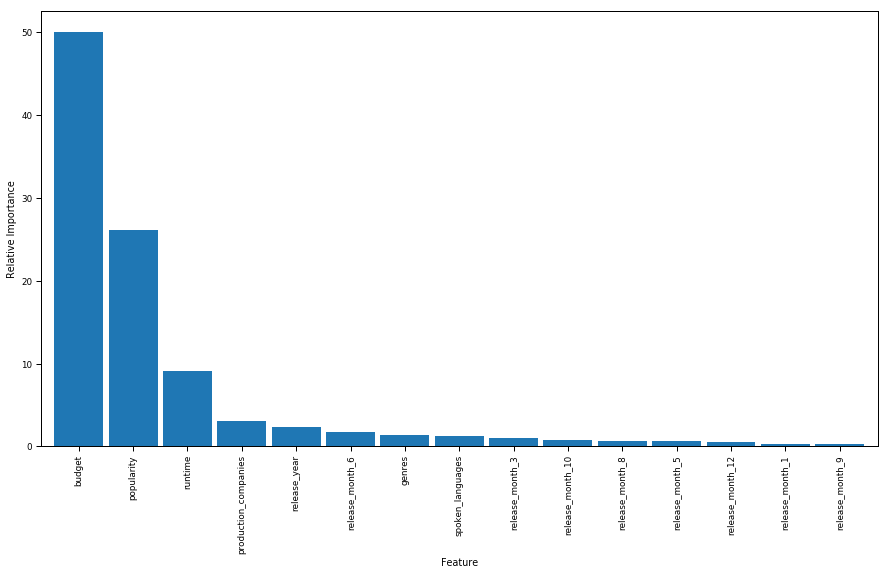

In [190]:
r = pd.DataFrame(columns=['Feature','Importance'])
ncomp = 15
r['Feature'] = feat_labels = x_test.columns
r['Importance'] = main_model.feature_importances_
r.set_index(r['Feature'], inplace=True)
ax = r.sort_values('Importance', ascending=False)[:ncomp].plot.bar(width=0.9, legend=False, figsize=(15,8))
ax.set_ylabel('Relative Importance')

### Test Data

In [191]:
df2 = pd.read_csv("../input/test.csv", low_memory=False)

In [192]:
df2.loc[(df2['budget'])==0].shape

(1211, 22)

In [193]:
def data_imputation(df2_test):
    
    df2_test[['release_month','release_day','release_year']]=df2_test['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df2_test['release_year'] = df2_test['release_year']
    df2_test.loc[ (df2_test['release_year'] <= 18) & (df2_test['release_year'] < 100), "release_year"] += 2000
    df2_test.loc[ (df2_test['release_year'] > 18)  & (df2_test['release_year'] < 100), "release_year"] += 1900
    
    df2_test = df2_test.filter(['id','budget','genres','popularity','production_companies','release_year',
                    'release_month','runtime','spoken_languages','revenue'])
    
    df3_impute = df2_test.dropna(axis=0)
    
    df3_impute['genres'] = df3_impute['genres'].apply(lambda x: conv_to_gen(x))
    df3_impute['production_companies'] = df3_impute['production_companies'].apply(lambda x: conv_to_gen(x))
    df3_impute['spoken_languages'] = df3_impute['spoken_languages'].apply(lambda x: conv_to_gen(x))
    
    df2_test['genres'].fillna(df3_impute['genres'].mode()[0], inplace=True)
    df2_test['production_companies'].fillna(df3_impute['production_companies'].mode()[0], inplace=True)
    df2_test['release_year'].fillna(df3_impute['release_year'].mode()[0], inplace=True)
    df2_test['release_month'].fillna(df3_impute['release_month'].mode()[0], inplace=True)
    df2_test['runtime'].fillna(df3_impute['runtime'].median(), inplace=True)
    df2_test['spoken_languages'].fillna(df3_impute['spoken_languages'].mode()[0], inplace=True)
    
    df2_test['genres'] = df2_test['genres'].apply(lambda x: conv_to_gen(x))
    df2_test['production_companies'] = df2_test['production_companies'].apply(lambda x: conv_to_gen(x))
    df2_test['spoken_languages'] = df2_test['spoken_languages'].apply(lambda x: conv_to_gen(x))
    df2_test['release_month'] = df2_test['release_month'].astype('str')
    df2_test = pd.get_dummies(df2_test, drop_first=True)
    
    return df2_test



In [194]:
df2 = data_imputation(df2)
test = df2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [195]:
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6856,'budget'] = 10 
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6

In [196]:
testdf = test

In [197]:
def testdata_predict_budget(df2):
    
    df_prediction = df2.drop('id',axis=1)
    df_prediction['_budget_runtime_ratio'] = df_prediction['budget']/df_prediction['runtime'] 
    df_prediction['_budget_popularity_ratio'] = df_prediction['budget']/df_prediction['popularity']
    df_prediction['_budget_year_ratio'] = df_prediction['budget']/(df_prediction['release_year']*df_prediction['release_year'])
    return df_prediction

In [198]:
testdata = testdata_predict_budget(testdf)

In [199]:
predictions = main_model.predict(testdata)
predictions[predictions<0] = 0

In [200]:
predictions

array([0.00000000e+00, 9.69434465e+06, 1.87270591e+07, ...,
       8.14416455e+07, 1.39137240e+08, 6.86361614e+06])

In [201]:
df2['revenue'] = predictions
df2['revenue']

0       0.000000e+00
1       9.694345e+06
2       1.872706e+07
3       2.575685e+07
4       5.879300e+06
5       2.536539e+07
6       1.497492e+07
7       4.901465e+07
8       3.954056e+07
9       2.719038e+08
10      0.000000e+00
11      6.278987e+06
12      3.917154e+07
13      0.000000e+00
14      4.249104e+07
15      0.000000e+00
16      1.191881e+08
17      1.456196e+08
18      1.992442e+07
19      6.356865e+08
20      7.066377e+07
21      6.584746e+07
22      0.000000e+00
23      4.192718e+07
24      0.000000e+00
25      1.158589e+08
26      1.168363e+07
27      1.234371e+08
28      0.000000e+00
29      7.822985e+07
            ...     
4368    4.200693e+07
4369    5.938709e+07
4370    0.000000e+00
4371    1.110496e+08
4372    3.541635e+08
4373    3.227153e+07
4374    9.663690e+07
4375    0.000000e+00
4376    2.941087e+07
4377    1.466306e+08
4378    6.226630e+07
4379    6.369463e+06
4380    0.000000e+00
4381    0.000000e+00
4382    0.000000e+00
4383    2.451198e+07
4384    5.598

In [202]:
df_submission = df2[['id','revenue']]

In [203]:
df_submission.to_csv('submission.csv', index=False)